In [1]:
from datetime import datetime
from datetime import timedelta
import time

tu = timedelta(0)
tp = timedelta(0)

tu_atm = timedelta(0)
tu_pvt = timedelta(0)
tu_esp = timedelta(0)
tp_atm = timedelta(0)
tp_pvt = timedelta(0)
tp_esp = timedelta(0)

In [2]:
t1 = datetime.now()
start_time = datetime.now()

In [3]:
import pandas as pd
import numpy as np
import xlwings as xw
import os
import scipy.interpolate

from scipy.optimize import minimize
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
import matplotlib.dates
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import dateparser
import statistics
import math

#%pylab inline
#%matplotlib inline

from IPython.display import Image
from pandas.plotting import register_matplotlib_converters

import calc_well_param.calc_func
import calc_well_param.ccalc_pvt
import calc_well_param.cpipe
import calc_well_param.cesp

In [4]:
# Настройка папок
# Рабочей папкой считаем папку выше \Скрипт
cCurrentPath_ = os.path.split(os.path.abspath(''))[0]
# cWorkFolder = r'F:\Work'
cWorkFolder = cCurrentPath_
print('cWorkFolder =', cWorkFolder)


cWorkFolder = C:\Users\Damirchik\Documents\viwell


In [5]:
# Имена файлов
# Справочник насосов, разделитель табуляция
esp_file_name = r'Данные для виртуальной расходометрии\esp.txt'

Выбор источника низкочастотных данных

In [6]:
# если grad = False, то данные подгружаются из ШТР
grad = True
BSI = False #True # Используем высокочастотные сырые данные из БСИ

Список месторождений

In [7]:
oilfields = ['Вынгаяхинское'] 
#, 'Суторминское', 'Вынгаяхинское', 'Восточно-Пякутинское'

Данные по скважине

In [8]:
Dintake_ = 100 # Диаметр приемной сетки насоса (пока что одинаковый для всех)
KsepGasSep_ = 0.7 # Коэффициент сепарации
#TKsep_ = 89 # Температура сепарации
#Tintake_ = 20 # Температура на приеме
PVT_corr_ = 0 # PVT корреляция для записи в строку PVT

In [9]:
dt = datetime.now() - t1
tu += dt
tp += dt
print(f'Время выполнения тек:{dt}, всего Unifloc {tu}, Python {tp}')

Время выполнения тек:0:00:01.426193, всего Unifloc 0:00:01.426193, Python 0:00:01.426193


Первичное заполнение свойств PVT

In [10]:
t1 = datetime.now()

In [11]:
PVTdic = {}
PVTdic['PVTcorr'] = PVT_corr_
PVTdic['ksep_fr'] = float(KsepGasSep_)
PVTdic['qgas_free_sm3day'] = 0
dt = datetime.now() - t1
tp += dt

In [12]:
t1 = datetime.now()

In [13]:
def get_tube_and_pump_characteristics(well_name, oilfield_):
    aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера\ГРАД')

    df_pump = pd.read_excel(os.path.join(aPath,
        'БОМД. Оборудование актуальных паспортов_Филиал Муравленковскнефть ОАО Газпромнефть-ННГ_04.03.2020 14-57-02.xlsx'),
                            sheet_name='Основной_лист', header=3).dropna(axis=1, how = 'all')
    Nominal_production_ = df_pump.loc[(df_pump['№ скважины'] == well_name) & (
                    df_pump['Месторождение'] == oilfield_)]['Подача комплекта, м3'].values[0]
    df_pump = df_pump[['№ скважины', 'Месторождение', 'Глубина спуска','0_Типоразмер_Секции_ЭЦН', '1_Типоразмер_Секции_ЭЦН',
                  '1_Количество_ступеней', '2_Количество_ступеней', '3_Количество_ступеней',
                  '4_Количество_ступеней', '5_Количество_ступеней', '6_Количество_ступеней', '7_Количество_ступеней',
                    '8_Количество_ступеней', '9_Количество_ступеней']]
    df_pump = df_pump.loc[(df_pump['№ скважины'] == well_name) & (df_pump['Месторождение'] == oilfield_)].dropna(axis=1)
    Hpump_ = int(df_pump['Глубина спуска'])
    NumStage_ = int(np.sum(df_pump.iloc[0][4:]))
    ESP_name_ = str(df_pump['1_Типоразмер_Секции_ЭЦН'].values[0])

    # Получаем ID насоса по имени, если имени нет, нужно брать по напору

    df_ESP_id = pd.read_csv(os.path.join(aPath, 'ESP_base_unifloc.csv'), encoding="windows 1251", header=0, sep=';')
    try:
        ESP_id_ = df_ESP_id.loc[df_ESP_id['Модель'] == ESP_name_]['ID'].iloc[0]
    except:
        ESP_id_ = ESP_id_by_rate(Nominal_production_)


    ESP_name_unifloc_ = ESP_name(str(ESP_id_))

    #df_tube = pd.read_excel('ТР все скв Мессояха (есть НКТ).xlsx', header=2).dropna(axis=1, how='all')
    #df_tube = df_tube[['Скважина', 'Диаметр экспл.колонны', 'Диаметр НКТ']].dropna()
    #try:
    #    Dcas_ = df_tube.loc[df_tube['Скважина'] == well_name+'G']['Диаметр экспл.колонны'].iloc[0]
    #    Dtub_ = df_tube.loc[df_tube['Скважина'] == well_name+'G']['Диаметр НКТ'].iloc[0]
    #except:
    #    Dcas_ = df_tube.loc[df_tube['Скважина'] == well_name+'G2']['Диаметр экспл.колонны'].iloc[0]
    #    Dtub_ = df_tube.loc[df_tube['Скважина'] == well_name+'G2']['Диаметр НКТ'].iloc[0]
    #
    #

    Dcas_ = 178 #Типичный размер ЭК для данного мр-я

    # Значения диаметра НКТ от глубины
    if BSI == False:
        aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                'ГРАД', oilfield_, r'Ствол\НКТ')
        for file in os.listdir(aPath):
            if well_name in file:
                filename = file
        d_tube_df = pd.read_excel(os.path.join(aPath, filename), header=1)
        d_tube_df['Глубина окончания секции'] = d_tube_df['длина,м'][0]
        for i in range(0, len(d_tube_df)):
            d_tube_df['Глубина окончания секции'].loc[i] = np.sum(d_tube_df['длина,м'][:i+1])
        d_tube_df['диаметр(мм)/сортамент'] = d_tube_df['диаметр(мм)/сортамент'].str.slice(0,2)
        d_tube_df['диаметр(мм)/сортамент'].astype(int)
    else:
        d_tube_df = pd.DataFrame()

    data = {'Hpump_' : Hpump_, 'NumStage_' : NumStage_, 'Dcas_' : Dcas_, 'Dtub_' : d_tube_df, 'ESP_id_' : ESP_id_,
           'ESP_name_' : ESP_name_, 'ESP_name_unifloc_' : ESP_name_unifloc_}

    return data

In [14]:
def get_inclinometry(well_name):
    
    aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                 'ГРАД', oilfield_, r'Ствол\Инклинометрия')
    for file in os.listdir(aPath):
        if well_name in file:
            filename = file
    df = pd.read_excel(os.path.join(aPath, filename), header=0).dropna(axis=1, how = 'all')
    df['Inc'].astype(float)
    df[['Inc']] = 90 - df[['Inc']]
    return df

In [15]:
def get_averaged_data(low, well_name):
# Функция считывает данные за 3 часа или 8 часов в зависимости от флага low. 
    aPath = ''
    if low:
        if grad and BSI:
            aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                                  'ГРАД', oilfield_, r'Осреднение\High freq')
        else:
            aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск',
                         r'информация для виртуального расходомера\ШТР', oilfield_)

        for file in os.listdir(aPath):
            if well_name in file:
                filename = os.path.join(aPath, file)
        res = get_data_both(low, well_name, filename)

    else:
        if BSI == False:
            aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                                  'ГРАД', oilfield_, r'Осреднение\High freq')
        elif grad and BSI:
            aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                         r'БСИ', oilfield_)
        for file in os.listdir(aPath):
            if well_name in file:
                filename = os.path.join(aPath, file)
        res = get_data_both(low, well_name, filename)
       
    return res
    

In [16]:
def get_data_both(low, well_name, filename):
# Считывание осредненных данных (3 часа или сутки)
    #if low and grad:
    if low and grad:
        df = pd.read_csv(filename, encoding="utf-8-sig", sep=',', index_col=0)
        df.index = pd.to_datetime(df.index)

        #df['Дебит газа (ТМ)'].interpolate(limit_direction='both', inplace=True)
        df['Газовый фактор (рассчитанный)'] = df['Дебит газа (ТМ)'] / df['Дебит нефти (ТМ)']
        df['Газожидкостной фактор (рассчитанный)'] = df['Дебит газа (ТМ)'] / df['Дебит жидкости (ТМ)']
        df['Обводненность (ТМ)'].interpolate(limit_direction='both', inplace=True)

        return df

    elif low == False and grad and BSI:
        df = pd.read_excel(filename)
        df.set_index('Дата, Время', inplace=True)
        df.dropna(subset = ['акт.P,кВт'], inplace=True)

        df.rename(columns={'F, Гц' : 'Частота вращения (ТМ)', 'Tдвиг, °C' : 'Температура двигателя ЭЦН (ТМ)',
                           'акт.P,кВт' : 'Активная мощность (ТМ)', 'P, ат.' : 'Давление на входе ЭЦН (ТМ)'},  inplace=True)
        return df
    else:
        if low:

            df = pd.read_excel(filename, header=2, parse_dates=['Unnamed: 0'], date_parser=dateparser.parse)
            df.rename(columns={'Unnamed: 0' : 'Дата', 'ГФР(ТМ)': 'Газожидкостной фактор (рассчитанный)',
                              'Обв ТМ' : 'Обводненность (ТМ)', 'Рэцн ТМ' : 'Давление на входе ЭЦН (ТМ)',
                              'Тдвиг ТМ' : 'Температура двигателя ЭЦН (ТМ)'}, inplace=True)
            df['Обводненность (ТМ)'] = (1 - df['Qн*'] / df['Qж ТМ']) * 100 # перевод в %
            df['Обводненность (ТМ)'].interpolate(limit_direction='both', inplace=True)
            df.set_index('Дата', inplace=True)
            df = df[['Газожидкостной фактор (рассчитанный)', 'Обводненность (ТМ)', 'Давление на входе ЭЦН (ТМ)',
                    'Температура двигателя ЭЦН (ТМ)']]

            os.chdir(r'F:\Work\Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера'
                r'\ГРАД' + '\\' + oilfield_ + r'\Осреднение\High freq')

            for file in os.listdir(os.getcwd()):
                if well_name in file:
                    filename = file

            df_grad = pd.read_csv(filename, encoding="utf-8-sig", sep=',', index_col=0)
            df_grad.index = pd.to_datetime(df_grad.index)

            if well_name == '6013':
                df_grad.drop(columns = ['Давление на входе ЭЦН (ТМ)', 'Дебит газа (ТМ)',
                                           'Дебит нефти (ТМ)', 'Обводненность (ТМ)'], inplace=True)
            if well_name == '3026':
                df_grad.drop(columns = ['Дебит нефти (ТМ)', 'Обводненность (ТМ)'], inplace=True)


            if 'Давление на входе ЭЦН (ТМ)' in df_grad.columns :
                df = df[['Газожидкостной фактор (рассчитанный)', 'Обводненность (ТМ)']]

            df = pd.concat([df_grad, df], axis=1).reindex(df_grad.index)
            df.dropna(how='all', inplace=True)
        elif grad == True:

            df = pd.read_csv(filename, encoding="utf-8-sig", sep=',', index_col=0)
            df.index = pd.to_datetime(df.index)

            df['Газовый фактор (рассчитанный)'] = df['Дебит газа (ТМ)'] / df['Дебит нефти (ТМ)']
            df['Газожидкостной фактор (рассчитанный)'] = df['Дебит газа (ТМ)'] / df['Дебит жидкости (ТМ)']
            df['Обводненность (ТМ)'].interpolate(limit_direction='both', inplace=True)
        else:
            df = pd.read_csv(filename, encoding="utf-8-sig", sep=',', index_col=0)
            df.index = pd.to_datetime(df.index)
        
        return df

In [17]:
def get_data_for_ml(df_calc, df_data):
    # возвращает подготовленные данные 
    df = pd.concat([df_calc, df_data.drop(columns=['Давление на входе ЭЦН (ТМ)', 'Температура двигателя ЭЦН (ТМ)', 
                                                       'Давление линейное (ТМ)'])], axis=1).reindex()
    return  df

In [18]:
def get_vsp(oilfield, well_name):
    # Чтение данных о ВСП (внутрисменные простои) скважин
    aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера\ВСП')
    for file in os.listdir(aPath):
        if oilfield in file:
            filename = file
    df = pd.read_csv(filename, encoding = 'windows 1251', sep=';')
    df.drop(columns=['Скв_оис', 'Состояние', 'Источник данных'], inplace=True)
    df.dropna(inplace=True)

    items = []
    for item in df['Скв'].values:
        if '_' in str(item):
            item = int(item[:-2])
        items.append(item)
    df['Скв'] = items
    df = df.loc[df['Скв'] == int(well_name)]
    df['ДатаСтарта'] = pd.to_datetime(df['ДатаСтарта'])
    df['Дата_Окончания'] = pd.to_datetime(df['Дата_Окончания'])
    return df

In [19]:
def get_data_for_validation(N, df_res, active_power_1H, f_esp_1H, *args):
 # Производим расчеты с выбросом некоторых дней с целью контроля ошибки!     
    

    df_res['K degradation'].iloc[-1] = df_res['K degradation'].iloc[-2]
    
    each_N_day = df_res.iloc[::N] # Данные за каждый N-й день 
    if N > 1:
        #ДФ с днями, на которых проверяем работу алгоритма (выкидывали каждый N-й день)   
        validation_days = df_res.drop(index=each_N_day.index) 
    else:
    #Для проверки последнего замера
        validation_days = df_res.iloc[-1:] 
        each_N_day.drop(index=validation_days.index, inplace=True)
        
    #resampled_k_deg = each_N_day[['K degradation']].resample('1H')

    
    if grad and BSI == False:
        resampled_k_deg = df_res[['K degradation']].resample('1H')
        interpolated_k_deg_1H = resampled_k_deg.interpolate('index')
        tKsep_1H = args[0]
        wc_1h = args[1]
        rp_1H = args[2]
        pksep_atma_1H = args[3]
        p_lin_1H = args[4]
        #resampled_f_esp = each_N_day[['F ESP']].resample('1H').interpolate()# Чтобы частота менялась плавнее внутри суток
        #resampled_temp = df_res['Temperature on the surface'].resample('1H').interpolate()
        
        # На случай, если нет высокочастотной обводненности
        #resampled_fw = each_N_day['Fw'].resample('1H').fillna(method='ffill') #Интерполируем обводненность внутри суток
        
        #resampled_tempKsep = df_res['Температура двигателя ЭЦН (ТМ)'].resample('1H').interpolate()
        #resampled_p_lin = df_res['Давление линейное (ТМ)'].resample('1H').interpolate()
        interpolated_rp = rp_1H.interpolate()
        
        return (pd.concat([active_power_1H, f_esp_1H, interpolated_k_deg_1H, tKsep_1H, wc_1h, p_lin_1H, interpolated_rp, 
                           pksep_atma_1H], axis=1).reindex(), validation_days)
    elif grad and BSI:
        resampled_k_deg = df_res[['K degradation']].resample('60S')
        interpolated_k_deg_1H = resampled_k_deg.interpolate('index')
        tKsep_1H = args[0]
        pksep_atma_1H = args[1]
        
        return (pd.concat([active_power_1H, f_esp_1H, interpolated_k_deg_1H, tKsep_1H, 
                           pksep_atma_1H], axis=1).reindex(), validation_days)
    else:
        p_lin_1H = args[0]
        resampled_k_deg = df_res[['K degradation']].resample('1H')
        interpolated_k_deg_1H = resampled_k_deg.interpolate('index')
        resampled_tempKsep = df_res['Температура двигателя ЭЦН (ТМ)'].resample('1H').interpolate()
        resmpled_pksep_atma = df_res['Давление на входе ЭЦН (ТМ)'].resample('1H').interpolate()
        resampled_fw = df_res['Fw'].resample('1H').fillna(method='ffill')
        resampled_rp = df_res['Газожидкостной фактор (рассчитанный)'].resample('1H').interpolate()
        return (pd.concat([active_power_1H, f_esp_1H, interpolated_k_deg_1H, resampled_tempKsep, resampled_fw, p_lin_1H, 
                           resampled_rp, resmpled_pksep_atma], axis=1).reindex(), validation_days)

In [20]:
def create_power_from_production_table(NumStage_, Freq_, ESP_id_, mu_):
    # Для создания табличной функции дебита от мощности. 

    production = [5, 10]
    power = [ESP_power_W(production[0], NumStage_, Freq_, ESP_id_, mu_)/1000, 
             ESP_power_W(production[-1], NumStage_, Freq_, ESP_id_, mu_)/1000] 
    i = 1
    while power[i]  != power[i-1] and production[-1] < 1000: #production[-1] < np.floor(Mean_prod_ * 1.2):
        production.append(production[-1] + 5)
        power.append(ESP_power_W(production[-1], NumStage_, Freq_, ESP_id_, mu_)/1000)
        i += 1
    if len(power) > 2:
        del power[-1]
        del production[-1]
    
    diff = np.gradient(power, production)
    df = pd.DataFrame(columns = ['Production', 'Power', 'Derivative'])
    df['Production'] = production
    df['Power'] = power
    df['Derivative'] = diff
    return df


In [21]:
def create_power_from_production_table_py(NumStage_, Freq_, ESP_id_, mu_, ESP_manufacturer_py, ESP_name_unifloc_py,
                                          ESP_nom_rate_py, ESP_max_rate_m3day_py):
    # Для создания табличной функции дебита от мощности.

    production = [5, 10]
    power = [ESP_power_W(production[0], NumStage_, Freq_, ESP_id_, mu_)/1000,
             ESP_power_W(production[-1], NumStage_, Freq_, ESP_id_, mu_)/1000]

    esp = calc_well_param.cesp.esp(id_pump=ESP_id_, manufacturer_name=ESP_manufacturer_py,
                                       pump_name=ESP_name_unifloc_py,
                                       freq_hz=ESP_freq_py, esp_nom_rate_m3day=ESP_nom_rate_py,
                                       esp_max_rate_m3day=ESP_max_rate_m3day_py,
                           esp_polynom_head_obj=esp_polynom_head, esp_polynom_efficency_obj=esp_polynom_efficency,
                           esp_polynom_power_obj=esp_polynom_power)

    esp.mu_cSt = float(mu_)
    esp.correct_visc = True
    esp.freq_hz = float(Freq_)
    esp.stage_num = NumStage_
    power_w = [esp.esp_power_w(aqliq_m3day=production[0]) / 1000, esp.esp_power_w(aqliq_m3day=production[-1]) / 1000]

    i = 1
    while power[i]  != power[i-1] and production[-1] < 1000: #production[-1] < np.floor(Mean_prod_ * 1.2):
        production.append(production[-1] + 5)
        power.append(ESP_power_W(production[-1], NumStage_, Freq_, ESP_id_, mu_)/1000)
        i += 1
    if len(power) > 2:
        del power[-1]
        del production[-1]

    diff = np.gradient(power, production)
    df = pd.DataFrame(columns = ['Production', 'Power', 'Derivative'])
    df['Production'] = production
    df['Power'] = power
    df['Derivative'] = diff
    return df


In [22]:
def get_Q_prediction(low, df, First_liq_point_,
                         NumStage_, Freq_start_, ESP_id_, mu_, passport_power_table, Fw_mean_, well_name, aPath):
    # Предсказание через напорно-расходную хар-ку
    q_predicted_array = [] # Массив предсказанных дебитов в условиях насоса
    q_liq_surface = [] # Массив предсказанных дебитов в поверхностных условиях
    counter_off_bounds = 0 # Счетчик точек, не попавших на паспортную хар-ку
    mu_array = [] # Массив вязкостей
    max_dQ_array = [] # Массив максимальных допустимых изменений дебита с учетом напорной хар-ки на текущем шаге



    for i in range(len(df)):

        ajusted_flag = False # Указывает, варьировалась ли вязкость, если true, то нужно перестраивать напорно-расходную

        if i != 0:
            mu_temp = mu_ # Параметр для варьирования вязкости
            Freq_ = df['F ESP'].iloc[i]
            #Fw_ = df['Fw'].iloc[i]

            #mu_ = int(include_emulsion(Fw_))

            if Freq_ != Freq_start_:
                Freq_start_ = Freq_
                passport_power_table = create_power_from_production_table(NumStage_, Freq_start_, ESP_id_, mu_)
                plot_pump(passport_power_table, well_name, Freq_start_, mu_, aPath)
                #print('new pass because of another frequency')



            #Q_old = interpolated_power(df['Expected power'].iloc[i] # Значение дебита на прошлом шаге
            N_passport = passport_power_table['Power'].values
            Q_passport = passport_power_table['Production'].values

            Q_result = np.empty(0)
            Q_for_interpolating = []
            N_for_interpolating = []
            n_new = df['Expected power'].iloc[i]
            if low == True:
                Q_old = df['Q mix pump cond'].iloc[i-1]
            else:
                Q_old = q_predicted_array[i-1]

            for j in range(1, len(N_passport)):
                if (N_passport[j-1] <= n_new and N_passport[j] >= n_new) or (
                    N_passport[j-1] >= n_new and N_passport[j] <= n_new):

                    N_for_interpolating = [N_passport[j-1], N_passport[j]]
                    Q_for_interpolating = [Q_passport[j-1], Q_passport[j]]
                    interpolated_power = scipy.interpolate.interp1d(N_for_interpolating, Q_for_interpolating)
                    Q_result = np.append(Q_result, interpolated_power(n_new))

            print('Possible Q is', Q_result)

            if len(Q_result) != 0:
                if Q_old == 0:
                    #Если модель ушла в 0, то опираемся на последнее ненулевое значение
                    Q_old = q_predicted_array[[i for i, e in enumerate(q_predicted_array) if e != 0][-1]]
                Q = Q_result.flat[np.abs(Q_result - Q_old).argmin()] #Предсказываем дебит ближайший к последнему != 0
                print('Selecting Q= ', Q)
            else:
                Q = 0
                print('Point out of model, Q = ', Q)
                counter_off_bounds += 1
            #interpolated_power = scipy.interpolate.interp1d(
            #    passport_power_table['Power'].values, passport_power_table['Production'].values,
            #    bounds_error=True)#"extrapolate")

            print('Expected power is {}'.format(df['Expected power'].iloc[i]))
            try:
                print('Real power is {}'.format(df['Active power'].iloc[i]))
            except:
                print('Real power is {}'.format(df['Active power 1H'].iloc[i]))
            print('Frequency is {}'.format(Freq_))

            if df['Expected power'].iloc[i] < 10 or Freq_ < 10:
                print('Pump is off!')
                Q = 0

            #else:
            #    if (df['Expected power'].iloc[i] < np.amax(passport_power_table['Power']) and
            #                df['Expected power'].iloc[i] > np.amin(passport_power_table['Power'])):
        #
            #         Q = interpolated_power(df['Expected power'].iloc[i])
            #    else:
            #        print('Off pass, expected power is {}, max = {}, min = {}'.format(
            #            df['Expected power'].iloc[i], np.amax(passport_power_table['Power']),
            #            np.amin(passport_power_table['Power'])))
            #
            #        #mu_temp = mu_ # Параметр для варьирования вязкости
            #        counter_off_bounds += 1
            #        while (df['Expected power'].iloc[i] > np.amax(passport_power_table['Power']) or
            #                    df['Expected power'].iloc[i] < np.amin(passport_power_table['Power'])):
        #
            #            #plot_pump(passport_power_table, well_name, Freq_, mu_temp)
            #
            #            if df['Expected power'].iloc[i] > np.amax(passport_power_table['Power']):
            #                mu_temp += 0.5
            #                print('> ', mu_temp)
            #                print('Excpected = {}, max = {}, min = {}'.format(df['Expected power'].iloc[i],
            #                            np.amax(passport_power_table['Power']), np.amin(passport_power_table['Power'])))
            #            elif df['Expected power'].iloc[i] < np.amin(passport_power_table['Power']):
            #                mu_temp -= 0.5
            #                print('< ', mu_temp)
            #                print('Excpected = {}, max = {}, min = {}'.format(df['Expected power'].iloc[i],
            #                                np.amax(passport_power_table['Power']), np.amin(passport_power_table['Power'])))
            #            if mu_temp <= 0 or mu_temp > 5 * mu_:
            #
            #                Q_off = q_predicted_array[-1] # Если не хватило коррекции по вязкости
            #                print('mu_temp out of bounds, appending Q = ', Q_off)
            #                break
            #
            #            passport_power_table = create_power_from_production_table(NumStage_, Freq_start_, ESP_id_,
            #                                                                      mu_temp, Mean_prod_)
            #            #plot_pump(passport_power_table, well_name, Freq_, mu_temp)
            #
        #
            #        #mu_array.append(mu_temp)
            #        ajusted_flag = True
            #
            #        print('Well {} adjusted, mu value is {}, mu from passport is {}, Freq is {} counter = {}'.format(
            #            well_name, mu_temp, mu_, Freq_, counter_off_bounds))
            #        #plot_pump(passport_power_table, well_name, Freq_, mu_temp)
            #
    #
            #
            #    interpolated_power = scipy.interpolate.interp1d(
            #        passport_power_table['Power'].values, passport_power_table['Production'].values,
            #        bounds_error=True)#"extrapolate")
            #    if mu_temp <= 0 or mu_temp > 5 * mu_:
            #        Q = Q_off
            #    else:
            #        Q = interpolated_power(df['Expected power'].iloc[i])
            #
            #    mu_array.append(mu_temp)


            #try:
            #
            #    interpolated_power = scipy.interpolate.interp1d(
            #        passport_power_table['Power'].values, passport_power_table['Production'].values,
            #        bounds_error=True)#"extrapolate")
            #    Q = interpolated_power(df['Expected power'].iloc[i])
            #
            #except:
            #    if len(df) > 300: #чтобы выводить только для 3-х часового предсказания
            #        counter_off_bounds += 1
            #    #print('Well {} is out of passport, adding average'.format(well_name))
            #    temp = np.asarray(q_predicted_array)
            #    mean = temp[temp > 0].mean() # При ошибке добавляем среднее на текущий момент значение (без -1)
            #    if len(q_predicted_array) == 0:
            #        mean = 0
            #    interpolated_power = scipy.interpolate.interp1d(
            #        passport_power_table['Power'].values, passport_power_table['Production'].values,
            #        bounds_error=False, fill_value = mean )
            #    Q = interpolated_power(df['Expected power'].iloc[i])
            #    print('Well {} is out of passport, expected power is {}, freq {}, mu {}'.format(well_name,
            #                                                               df['Expected power'].iloc[i], Freq_, mu_))



            #print(i, ' ', Q, ' ',  df.iloc[i])

            #if Q > 0 and Q < 3 * max(q_mix_array):
            #    q_predicted_array.append(Q)
            #else:
            #    try:
            #        q_predicted_array.append(q_predicted_array[-1])
            #    except:
            #        q_predicted_array.append(0)

            # Все значения, не попавшие в диапазон, берем = 0

        Max_deriv_ = abs(max(passport_power_table['Derivative'].values)) # Максимальное зн-е производной N'q
        dN_ = abs(df['dN expected'].iloc[i])
        Max_dQ = abs(dN_ / Max_deriv_) # Максимально возможное изменение дебита

        max_dQ_array.append(Max_dQ)

        if i == 0:
            Q = First_liq_point_ # Доверяем первому замеру

        q_predicted_array.append(Q)

        #!!!!
        #Дебит на поверхности

        q_liq_surface.append(transform_to_surface_conditions(Q, i, df))
        #!!!!

        #print('Q pump is {}'.format(Q))
        #print('Expected power is ', df['Expected power'].iloc[i])
        #print(passport_power_table)

        if ajusted_flag == True:
            passport_power_table = create_power_from_production_table(NumStage_, Freq_start_, ESP_id_, mu_)

        print('Date is {}, Q predicted is {}, progress is {}%'.format(df.index[i], Q, np.round(i/len(df) * 100, 2)))

    if low == False: #чтобы выводить только для 3-х часового предсказания
        print('Total number of points out of interpolation is {}'.format(counter_off_bounds))
        #total_off_bounds = counter_off_bounds

    return (q_predicted_array, counter_off_bounds, mu_array, max_dQ_array, q_liq_surface)

In [23]:
def get_error_for_optimization(Q, args):
    
    i = args[0] # Текущая точка в предсказанном массиве
    df = args[1] # ДФ со всеми данными
        
    Q_true = args[2] #Реальный дебит модели в условиях насоса
    Fw_ = df['Fw'].iloc[i]
    #Temperature = df['Temperature on the surface'].iloc[i]
    Pksep_atma_ = df['Давление на входе ЭЦН (ТМ)'].iloc[i]
    TKsep_ = df['Температура двигателя ЭЦН (ТМ)'].iloc[i]
    Rp_ = df['Газожидкостной фактор (рассчитанный)'].iloc[i]
    
    PVT_str = PVT_encode_string(gamma_gas_, gamma_oil_,gamma_wat_, Rsb_, Rp_, Pb_, Tres_, Bob_, mu_, PVT_corr_, 
                                KsepGasSep_, float(Pksep_atma_), float(TKsep_))
    
    Q_predicted = MF_q_mix_rc_m3day(float(Q), Fw_, float(Pksep_atma_), float(TKsep_), PVT_str)
    error = math.sqrt((Q_predicted - Q_true)**2)
    
    return error

In [24]:
def transform_to_surface_conditions(Q_pump, i, df):
   
    Q_start = 100 # Стартовая точка оптимизации
        
    minimized_result = minimize(get_error_for_optimization, Q_start, method = 'Nelder-Mead', 
                                args=[i, df, Q_pump]) #Запуск оптимизатора
    #print('True value is {}, predicted is {}, error is {}'.format(Q_pump, minimized_result.x[0], 
    #                                                              np.abs(Q_pump - minimized_result.x[0])/Q_pump))
    #print(minimized_result)
    print('{}% completed'.format(np.round(i/len(df) * 100, 2)))
    
    return minimized_result.x[0]

In [25]:
def ml_calculations(df_day, df_3h, well_name):
    
# Расчеты по МО, обучение и контроль ошибки на дневных данных, применяем обученные модели для 3 часовых 

    y = df_day['K degradation'].values
    df_day.drop(columns=['K degradation'], inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(df_day, y, test_size=0.2, shuffle=True)
    ten_pow = np.power(10.0, np.arange(-4, 2))
    grid = {'alpha': ten_pow}
    cv = KFold(n_splits = 5, shuffle = True)
    clf_test = Ridge()
    gs = GridSearchCV(clf_test, grid, cv=cv)
    gs.fit(X_train,  y_train)
    print(gs.best_estimator_)
    
    model = gs.best_estimator_
    model.fit(X_train, y_train)
    
    
    y_pred_ridge_train = model.predict(X_train)
    y_pred_ridge_test = model.predict(X_test)
    
        
    train_r2_ridge = r2_score(y_train, y_pred_ridge_train)
    test_r2_ridge = r2_score(y_test, y_pred_ridge_test)
    
    train_mae_ridge = mean_absolute_error(y_train, y_pred_ridge_train)
    test_mae_ridge = mean_absolute_error(y_test, y_pred_ridge_test)
    
    y_res_ridge = model.predict(df_3h)

    
    model = RandomForestRegressor(max_depth=4, n_estimators=25, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred_forest_train = model.predict(X_train)
    y_pred_forest_test = model.predict(X_test)
    
    train_r2_forest = r2_score(y_train, y_pred_forest_train)
    test_r2_forest = r2_score(y_test, y_pred_forest_test)
  
    train_mae_forest = mean_absolute_error(y_train, y_pred_forest_train)
    test_mae_forest = mean_absolute_error(y_test, y_pred_forest_test)
    
    y_res_forest = model.predict(df_3h)
    
    aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера', 
                          'ГРАД', oilfield_, r'Результаты\ML')
    
    n_features = df_day.shape[1]
    plt.figure(figsize = (25,12))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df_day.columns)
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
    plt.title('Скважина ' + well_name + ' Feature importances')
    plt.tight_layout()
    plt.savefig(os.path.join(aPath, 'Скважина ' + well_name + ' Feature importances' + '.jpg'))
    plt.close();
    
    return {'Ridge' : y_res_ridge, 'Forest' : y_res_forest , 'train_r2_ridge' : train_r2_ridge , 
            'test_r2_ridge' : test_r2_ridge, 'train_mae_ridge' : train_mae_ridge, 'test_mae_ridge' : test_mae_ridge, 
            'train_r2_forest' : train_r2_forest, 'test_r2_forest' : test_r2_forest, 
            'train_mae_forest' : train_mae_forest, 'test_mae_forest' : test_mae_forest}

In [26]:
def visualisation(df_res, summary_df, df_vsp, well_name):#, df_ml_high , well_name):
    aPath = ''
    if grad:
        aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                              'ГРАД', oilfield_, r'Результаты\Plots')
    else:
        aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                                 'ГРАД', oilfield_, r'Результаты\Plots\SHTR')

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=summary_df.index,y=summary_df['Expected production'], mode='lines+markers',name="Expected production high freq (pump conditions)"))
    
    fig.add_trace(
        go.Scatter(x=summary_df.index,y=summary_df['Expected production on the surface'], mode='lines+markers', 
                   name="Expected production high freq (surface conditions)")
    )
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Expected production daily'], mode='lines+markers', 
                   name="Expected production daily (pump conditions)")
    )
      
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Expected daily production on the surface'], mode='lines+markers', 
                   name="Expected production daily (surface conditions)")
    )
     
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Q mix pump cond'], marker={'size':10}, mode='lines+markers', 
                   name="Real production (pump conditions)")
    )
   
    fig.add_trace(
    go.Scatter(x=df_res.index, y=df_res['Дебит жидкости (ТМ)'], marker={'size':10}, mode='lines+markers', 
                   name="Real production (surface)")
    )
    
       
    
    
    #fig.add_trace(
    #    go.Scatter(x=df_ml_high.index, y=df_ml_high['K ridge'], mode='lines+markers', name="K degradation predicted ridge")
    #)
    #
    #
    #fig.add_trace(
    #    go.Scatter(x=df_ml_high.index, y=df_ml_high['K forest'], mode='lines+markers', 
    #               name="K degradation predicted forest")
    #)
   
   
    
    fig.add_trace(
        go.Scatter(x=summary_df.index,y=summary_df['K degradation'], mode='markers', name="K deg interpolated")
    )
    
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['K degradation'], mode='markers', name="K deg")
    )
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Газожидкостной фактор (рассчитанный)'], mode='lines+markers', 
                   name="Gas-liquid factor")
    )
    
    #fig.add_trace(
    #    go.Scatter(x=summary_df.index,y=summary_df['Fw'], mode='markers', name="WC")
    #)
    
    fig.add_trace(
        go.Scatter(x=summary_df.index, y=summary_df['Active power 1H'], mode='lines+markers', name="Active power 1H")
    )
    
    fig.add_trace(
        go.Scatter(x=summary_df.index, y=summary_df['Expected power'], mode='lines+markers', name="Expected power 1H")
    )
    
    fig.add_trace(
        go.Scatter(x=summary_df.index, y=summary_df['F ESP'], mode='lines+markers', name="ESP frequency")
    )
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Active power'], mode='lines+markers', name="Active power (low)")
    )
    
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['F ESP'], mode='lines+markers', name="ESP frequency (low)")
    )
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Давление на входе ЭЦН (ТМ)'], mode='lines+markers', name="Intake pressure")
    )    
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Давление линейное (ТМ)'], mode='lines+markers', name="Wellhead pressure")
    )
    
    #fig.add_trace(
    #    go.Scatter(x=summary_df.index, y=summary_df['Давление линейное (ТМ)'], mode='lines+markers', name="Wellhead pressure")
    #)

    
    #fig.add_trace(
    #    go.Scatter(x=summary_df.index, y=summary_df['mu emulsion'], mode='lines+markers', name="mu emulsion")
    #)
    #
    #fig.add_trace(
    #    go.Scatter(x=df_res.index, y=df_res['mu emulsion'], mode='lines+markers', name="mu emulsion daily")
    #)
    #
    #fig.add_trace(
    #    go.Scatter(x=df_ml_3h.index, y=df_ml_3h['Давление на входе ЭЦН (ТМ)'],
    #                   mode='lines+markers', name="Pump intake pressure")
    #    )
    
    if len(df_vsp) != 0:
        shapes=[
            dict(
                type="rect",
                # x-reference is assigned to the x-values
                xref="x",
                # y-reference is assigned to the plot paper [0,1]
                yref="paper",
                x0=df_vsp['ДатаСтарта'].iloc[i],
                y0=0,
                x1=df_vsp['Дата_Окончания'].iloc[i],
                y1=max(summary_df['Expected production']),
                fillcolor="LightSalmon",
                opacity=0.3,
                layer="below",
                line_width=0) for i in range(len(df_vsp))]
            
        fig.update_layout(
            shapes=shapes
            )
    if grad:
        fig.update_layout(
            title_text= well_name + ' GRAD', template='plotly_white'
        )
    else:
        fig.update_layout(
            title_text= well_name + ' SHTR', template='plotly_white'
        )        
                    
    
    fig.update_xaxes(title_text="Дата")
    
    #fig.update_yaxes(title_text="Production m3/day")
    if grad:
        aPathWithFileName = os.path.join(aPath, well_name + ' GRAD.html')
        plotly.offline.plot(fig, filename = aPathWithFileName, auto_open=False)
    else:
        aPathWithFileName = os.path.join(aPath, well_name + ' SHTR.html')
        plotly.offline.plot(fig, filename = aPathWithFileName, auto_open=False)
    
    #fig.show()


In [27]:
def plot_pump(passport_power_table, well_name, Freq_, mu_, aPath):
    # Функция построения напорно-расходной хар-ки по мощности
    fig,ax = plt.subplots(figsize=(15,15))
    plt.tight_layout()
    ax.plot(passport_power_table['Production'], passport_power_table['Power'])
    ax.set_xlabel("Production",fontsize=14)
    ax.set_ylabel("Power",fontsize=14)
    ax2=ax.twinx()
    ax2.plot(passport_power_table['Production'], passport_power_table['Derivative'], color='red')
    ax2.set_ylabel("Derivative",fontsize=14)
    aFileName = well_name + ', Freq = ' + str(Freq_) + ', mu = ' + str(mu_) + '.jpg'
    plt.savefig(os.path.join(aPath, aFileName), quality=100)
    plt.close()


In [28]:
def plot_error(validation_df, well_name):
        # Функция постороения напорно-расходной хар-ки по мощности
    path = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера', 
                          'ГРАД', oilfield_, r'Результаты\Error')
    os.chdir(path)
    plt.figure(figsize = (10,10))
    plt.title(well_name + ' cross-plot')
    plt.scatter(validation_df['Q mix pump cond'], validation_df['Expected production'])
    plt.xlabel('Q mix pump cond')
    plt.ylabel('Expected production')
    plt.savefig(os.path.join(path, well_name + ' cross-plot' + '.jpg'), quality=100)
    plt.close()


In [29]:
def test_optimization(df):
    Q_for_test = []
    for i in range(len(df)):
        
        
        Q = df['Expected daily production on the surface'].iloc[i]
        Fw_ = df['Fw'].iloc[i]
        Pksep_atma_ = df['Давление на входе ЭЦН (ТМ)'].iloc[i]
        TKsep_ = df['Температура двигателя ЭЦН (ТМ)'].iloc[i]
        Rp_ = df['Газожидкостной фактор (рассчитанный)'].iloc[i]
        PVT_str = PVT_encode_string(gamma_gas_, gamma_oil_,gamma_wat_, Rsb_, Rp_, Pb_, Tres_, Bob_, mu_, PVT_corr_, 
                                    KsepGasSep_, float(Pksep_atma_), float(TKsep_))
        
        Q_for_test.append(MF_q_mix_rc_m3day(float(Q), Fw_, float(Pksep_atma_), float(TKsep_), PVT_str))
    
    df['Q test pump conditions'] = Q_for_test
        
    fig = go.Figure()
    
    fig.add_trace(
        go.Scatter(x=df.index,y=df['Q test pump conditions'], mode='lines+markers', 
                   name="Test pump")
    )
    
    fig.add_trace(
        go.Scatter(x=df.index,y=df['Expected production daily'], mode='lines+markers', 
                   name="Expected production high freq (pump conditions)")
    )
    
    fig.update_layout(
        title_text='Test', template='plotly_white'
    )
    fig.update_xaxes(title_text="Дата")
    
    
    plotly.offline.plot(fig, filename = 'Optimization test.html', auto_open=False)

Функция загрузки базы насосов для py-скрипта

In [30]:
def prepare_esp_base(file_name):
    curr_path = os.path.join(cWorkFolder, file_name)
    esp_table = pd.read_table(curr_path)
    return esp_table

Подключение функций Unifloc

In [31]:
dt = datetime.now() - t1
tu += dt
tp += dt
t1 = datetime.now()

In [32]:
wb = xw.Book(os.path.join(cWorkFolder, r'VMetring\unifloc 7_14\UniflocVBA_7.xlam'))
app = wb.app
PVT_encode_string = app.macro('PVT_encode_string') 
MF_q_mix_rc_m3day = app.macro('MF_q_mix_rc_m3day')
MF_gas_fraction_d = app.macro('MF_gas_fraction_d')
ESP_power_W = app.macro('ESP_power_W')
MF_p_pipe_atma = app.macro('MF_p_pipe_atma')
ESP_id_by_rate = app.macro('ESP_id_by_rate')
ESP_name = app.macro('ESP_name')

dt = datetime.now() - t1
tu += dt

Вычисления

In [33]:
for oilfield_ in oilfields:
    t1 = datetime.now()
    if oilfield_ == 'Суторминское':
        gamma_oil_ = 0.808
        gamma_wat_ = 1
        gamma_gas_ = 0.754
        Rsb_ = 15.6
        Rp_ = 186
        Pb_ = 138.7
        Tres_ = 76
        Bob_ = 1.486
        mu_ = 2.846 # Вязкость нефти, из PVT
    elif oilfield_ == 'Вынгаяхинское':
        gamma_oil_ = 0.82
        gamma_wat_ = 1
        gamma_gas_ = 0.796
        Rsb_ = 15.6
        Rp_ = 124
        Pb_ = 139
        Tres_ = 89
        Bob_ = 1.278
        mu_ = 7.76 # Вязкость нефти, из PVT
    elif oilfield_ == 'Восточно-Пякутинское':
        gamma_oil_ = 0.846
        gamma_wat_ = 1
        gamma_gas_ = 0.712
        Rsb_ = 15.6
        Rp_ = 73
        Pb_ = 122.4
        Tres_ = 85
        Bob_ = 1.168
        mu_ = 12.96 # Вязкость нефти, из PVT
    
    dt = datetime.now() - t1
    tu += dt
    tp += dt
    t1 = datetime.now()
    PVTdic['gamma_gas'] = float(gamma_gas_)
    PVTdic['gamma_oil'] = float(gamma_oil_)
    PVTdic['gamma_wat'] = float(gamma_wat_)
    PVTdic['rsb_m3m3'] = float(Rsb_)
    PVTdic['pb_atma'] = float(Pb_)
    PVTdic['tres_C'] = float(Tres_)
    PVTdic['bob_m3m3'] = float(Bob_)
    PVTdic['muob_cP'] = float(mu_)
    PVTdic['bwSC_m3m3'] = PVTdic['gamma_wat'] / 1
    PVTdic['salinity_ppm'] = calc_well_param.ccalc_pvt.unf_calc_Sal_BwSC_ppm(PVTdic['bwSC_m3m3'])
    
    dt = datetime.now() - t1
    
    tp += dt
        # Список скважин
    t1 = datetime.now()   
    aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                          'ГРАД', oilfield_, 'Скважины')
    
    filenames = []
    for file in os.listdir(aPath):
        filenames.append(file[:-4])
    print(filenames)
    
    #filenames = ['2355']
    
    N = 1 # Параметр для проверки качества модели (выкижываем каждую N-ю точку и считаем ошибку)
    # ДФ для записи всех логов и результатов
    log_df = pd.DataFrame(index = [filenames], columns=['ESP name real', 'ESP name used', 'ESP id', 
                                                        'Average production', 'MAE score', 'Average error, %', 
                                                        'Maximum absolute error', 'Average production surface', 
                                                        'MAE score surface', 'Average error surface, %', 
                                                        'Maximum absolute error surface', 'MAE score surface restoring', 
                                                        'Maximum absolute error surface restoring',
                                                        'Average error because incorrect passport, %', 
                                                        'Total № of points off passport bounds', 'R2 score',
                                                        'R2 test score ridge', 'R2 train score ridge', 
                                                        'MAE test score ridge', 'MAE train score ridge', 
                                                        'Average MAE test score ridge, %', 
                                                        'Average MAE train score ridge, %', 'R2 test score forest',
                                                        'R2 train score forest', 'MAE test score forest', 
                                                        'MAE train score forest', 'Average MAE test score forest, %', 
                                                        'Average MAE train score forest, %'])
################# вызов Виртуальный Расходомер начало
    log_df_py = pd.DataFrame(index=[filenames], columns=['ESP name real', 'ESP name used', 'ESP id',
                                                      'Average production', 'MAE score', 'Average error, %',
                                                      'Maximum absolute error', 'Average production surface',
                                                      'MAE score surface', 'Average error surface, %',
                                                      'Maximum absolute error surface', 'MAE score surface restoring',
                                                      'Maximum absolute error surface restoring',
                                                      'Average error because incorrect passport, %',
                                                      'Total № of points off passport bounds', 'R2 score',
                                                      'R2 test score ridge', 'R2 train score ridge',
                                                      'MAE test score ridge', 'MAE train score ridge',
                                                      'Average MAE test score ridge, %',
                                                      'Average MAE train score ridge, %', 'R2 test score forest',
                                                      'R2 train score forest', 'MAE test score forest',
                                                      'MAE train score forest', 'Average MAE test score forest, %',
                                                      'Average MAE train score forest, %'])
################# вызов Виртуальный Расходомер 

    dt = datetime.now() - t1
    tu += dt
    tp += dt
    for names in zip(range(len(filenames)), filenames):
        t1 = datetime.now()
        
        well_name = names[1]
        
        if well_name in ['6011', '6013', '1976', '3026', '337', '2338', '2355', '3900', '3922']:
            grad = False
        else:
            grad = True
            
        t1 = datetime.now()
        tube_and_pump = get_tube_and_pump_characteristics(well_name, oilfield_)
        dt = datetime.now() - t1
        tu += dt

        Hpump_ = tube_and_pump['Hpump_']
        NumStage_ = tube_and_pump['NumStage_']
        Dcas_ = tube_and_pump['Dcas_']
        #Dtub_ = tube_and_pump['Dtub_']
        Dtub_ = 79 #нехорошо
        ESP_id_ = int(tube_and_pump['ESP_id_'])
        ESP_name_ = tube_and_pump['ESP_name_']
        ESP_name_unifloc_ = tube_and_pump['ESP_name_unifloc_']
        
################# вызов Виртуальный Расходомер начало
        t1 = datetime.now()
        esp_base = prepare_esp_base(esp_file_name)
        pumps_for_id = esp_base[esp_base['ID'] == ESP_id_]
        ESP_name_unifloc_py = pumps_for_id['Модель'].iloc[0]
        ESP_manufacturer_py = pumps_for_id['Производитель'].iloc[0]
        ESP_freq_py = int(pumps_for_id['Частота'].iloc[0])
        ESP_nom_rate_py = int(pumps_for_id['Номинал'].iloc[0])
        ESP_stage_num_py = int(pumps_for_id['Ступеней макс'].iloc[0])
        ESP_max_rate_m3day_py = pumps_for_id['Дебит'].astype('float').max()
        esp_rates = []
        esp_heads = []
        esp_eff = []
        esp_powers = []
        for ind in range(len(pumps_for_id.index)):
           esp_rates.append(pumps_for_id.iloc[ind]['Дебит'])
           esp_heads.append(pumps_for_id.iloc[ind]['Напор'])
           esp_powers.append(pumps_for_id.iloc[ind]['Мощность'])
           esp_eff.append(pumps_for_id.iloc[ind]['КПД'])
        esp_heads_с = calc_well_param.cesp.polinom_solver(esp_rates, esp_heads, 5)
        esp_polynom_head = calc_well_param.cesp.esp_polynom(esp_heads_с)
        esp_eff_с = calc_well_param.cesp.polinom_solver(esp_rates, esp_eff, 5)
        esp_polynom_efficency = calc_well_param.cesp.esp_polynom(esp_eff_с)
        esp_powers_с = calc_well_param.cesp.polinom_solver(esp_rates, esp_powers, 5)
        esp_polynom_power = calc_well_param.cesp.esp_polynom(esp_powers_с)
        dt = datetime.now() - t1
        tp += dt
################# вызов Виртуальный Расходомер
        
        t1 = datetime.now()
        
        # По ШТР
        if grad == False and BSI == False:
            all_data = get_averaged_data(True, well_name)
            all_data_high = get_averaged_data(False, well_name)
            
        # По БСИ
        elif grad and BSI:
            all_data_high = get_averaged_data(False, well_name).resample('60S').mean()
            all_data = get_averaged_data(True, well_name)
            
        elif grad and BSI == False:
            all_data_high = get_averaged_data(False, well_name)
            all_data = all_data_high.dropna(subset=['Дебит жидкости (ТМ)'])
        else:
            print('ГЫГ')
            all_data = get_averaged_data(True, well_name)
            all_data.dropna(subset=['Дебит жидкости (ТМ)'], inplace=True)
        
        #all_data.dropna(subset=['Дебит жидкости (ТМ)'], inplace=True)
        #all_data['Активная мощность (ТМ)'].interpolate(limit_direction='both', inplace=True)
        all_data['Газожидкостной фактор (рассчитанный)'].interpolate(limit_direction='both', inplace=True) 
        all_data['Частота вращения (ТМ)'].interpolate(limit_direction='both', inplace=True) 
        all_data['Температура двигателя ЭЦН (ТМ)'].interpolate(limit_direction='both', inplace=True) 
        
        #df_vsp = get_vsp(oilfield_, well_name)
            
        if all_data.index[0] < all_data_high.index[0]:
            all_data = all_data.truncate(before = all_data_high.index[0])
            all_data_high = all_data_high.truncate(before = all_data.index[0])
            
        else:
            all_data_high = all_data_high.truncate(before = all_data.index[0])
            all_data = all_data.truncate(before = all_data_high.index[0])
        
        if all_data.index[-1] > all_data_high.index[-1]:    
            all_data = all_data.truncate(after = all_data_high.index[-1])
            all_data_high = all_data_high.truncate(after = all_data.index[-1])
        
        else:
            all_data_high = all_data_high.truncate(after = all_data.index[-1])
            all_data = all_data.truncate(after = all_data_high.index[-1])

        #if df_vsp.index[0] < all_data.index[0]:
        #    df_vsp = df_vsp.truncate(before = all_data.index[0])
        #if df_vsp.index[-1] > all_data.index[-1]:
        #    df_vsp = df_vsp.truncate(after = all_data.index[-1])
        
            
        print('Input data begins at {}, {}, ends at {}, {}'.format(all_data_high.index[0], all_data.index[0], 
                                                       all_data_high.index[-1], all_data.index[-1]))
        # Проверка на Мпа/атм
        print('Average pressure, ', all_data['Давление линейное (ТМ)'].dropna().mean())
        if all_data['Давление линейное (ТМ)'].dropna().mean() < 3:
            all_data['Давление линейное (ТМ)'] = all_data['Давление линейное (ТМ)'] * 9.869
            if BSI == False:
                all_data_high['Давление линейное (ТМ)'] = all_data_high['Давление линейное (ТМ)'] * 9.869
        
        if grad == False and BSI == False:
            active_power_1H = all_data_high[['Активная мощность (ТМ)']]
            f_esp_1H = all_data_high[['Частота вращения (ТМ)']]
            p_lin_1H = all_data_high[['Давление линейное (ТМ)']]
            
        if grad and BSI == False: 
            active_power_1H = all_data_high[['Активная мощность (ТМ)']]
            f_esp_1H = all_data_high[['Частота вращения (ТМ)']]
            p_lin_1H = all_data_high[['Давление линейное (ТМ)']]        
            tKsep_1H = all_data_high[['Температура двигателя ЭЦН (ТМ)']]
            pksep_atma_1H = all_data_high[['Давление на входе ЭЦН (ТМ)']]
            rp_1H = all_data_high[['Газожидкостной фактор (рассчитанный)']]
            wc_1h = all_data_high[['Обводненность (ТМ)']]
        
        if grad and BSI:
            active_power_1H = all_data_high[['Активная мощность (ТМ)']]#.resample('60S').mean()
            f_esp_1H = all_data_high[['Частота вращения (ТМ)']]#.resample('60S').mean()
            tKsep_1H = all_data_high[['Температура двигателя ЭЦН (ТМ)']]#.resample('60S').mean()
            pksep_atma_1H = all_data_high[['Давление на входе ЭЦН (ТМ)']]#.resample('60S').mean()

   
        
        f_esp_1H.rename(columns = {'Частота вращения (ТМ)' : 'F ESP'}, inplace=True)
        inclinometry = get_inclinometry(well_name)
        
        log_df.loc[well_name]['ESP name real'] = ESP_name_
        log_df.loc[well_name]['ESP name used'] = ESP_name_unifloc_
        log_df.loc[well_name]['ESP id'] = str(ESP_id_)
        
        pressure_at_the_discharge = []

################# вызов Виртуальный Расходомер начало
        pressure_at_the_discharge_py = []
################# вызов Виртуальный Расходомер

        k_deg = [] # Массив суточных коэффициентов деградации
        
        q_mix_array = [] # Массив суточных дебитов в условиях насоса
        
       
        passp_pow = [] # Массив паспортных мощностей раз в сутки
        
################# вызов Виртуальный Расходомер начало
        passp_pow_py = [] # Массив паспортных мощностей раз в сутки по результатам расчета python
        q_mix_array_py = [] # Массив суточных дебитов в условиях насоса по результатам расчета python
################# вызов Виртуальный Расходомер
      
        df_res = pd.DataFrame(index = all_data.index, columns = ['Q mix pump cond', 'K degradation'])
        Freq_start_ = all_data['Частота вращения (ТМ)'].iloc[0] # частота ЭЦН в первый день
        
################# вызов Виртуальный Расходомер начало
        df_res_py = pd.DataFrame(index = all_data.index, columns = ['Q mix pump cond', 'K degradation'])
################# вызов Виртуальный Расходомер начало
        dt = datetime.now() - t1
        tu += dt
        tp += dt        
        for i in range(len(all_data)):
            t1 = datetime.now()
            Rp_ = all_data['Газожидкостной фактор (рассчитанный)'].iloc[i]
            Pksep_atma_ = all_data['Давление на входе ЭЦН (ТМ)'].iloc[i]
            Qliq_ = all_data['Дебит жидкости (ТМ)'].iloc[i]
            Fw_ = all_data['Обводненность (ТМ)'].iloc[i]
            Fw_mean_ = all_data[['Обводненность (ТМ)']].mean()#[0]
            Active_pow_ = all_data['Активная мощность (ТМ)'].iloc[i]
                           
            
            #mu_ = int(include_emulsion(Fw_mean_))
            #mu_ = int(include_emulsion(Fw_))
                    
            Pintake_ = Pksep_atma_    
            Plin_ = all_data['Давление линейное (ТМ)'].iloc[i]
            Freq_ = all_data['Частота вращения (ТМ)'].iloc[i]
            TKsep_ = all_data['Температура двигателя ЭЦН (ТМ)'].iloc[i]
            Tintake_ = TKsep_

            dt = datetime.now() - t1
            tu += dt
            tp += dt        
            
            t1 = datetime.now()
            PVT_str = PVT_encode_string(gamma_gas_, gamma_oil_,gamma_wat_, Rsb_, Rp_, Pb_, Tres_, Bob_, mu_, PVT_corr_, 
                                        KsepGasSep_, float(Pksep_atma_), float(TKsep_))
            pressure_full_temp = [Plin_] # Распределение давления по стволу (свое в каждый день)
            dt = datetime.now() - t1
            tu += dt
################# вызов Виртуальный Расходомер начало
            t1 = datetime.now()
            PVTdic['pksep_atma'] = float(Pksep_atma_)
            PVTdic['tksep_C'] = float(TKsep_)
            PVTdic['rp_m3m3'] = float(Rp_)
            pressure_full_temp_py = [Plin_] # Распределение давления по стволу (свое в каждый день)
            dt = datetime.now() - t1
            tp += dt        
################# вызов Виртуальный Расходомер
            
            j = 1
            while inclinometry['MD'].iloc[j] < Hpump_:
                Length_ = inclinometry['MD'].iloc[j] - inclinometry['MD'].iloc[j-1]
                Pcalc_ = pressure_full_temp[j-1]
                Calc_along_flow_ = 0
                Theta_deg = inclinometry['Inc'].iloc[j]
                Hydr_corr_ = 0
                Tcalc_ = Tres_
                Tother_ = Tcalc_

                t1 = datetime.now()
                pressure_full_temp.append(MF_p_pipe_atma(Qliq_, Fw_, int(Length_), Pcalc_, Calc_along_flow_, 
                                                         PVT_str, Theta_deg, Dtub_, Hydr_corr_, Tcalc_, Tother_)[0])
                dt = datetime.now() - t1
                tu += dt
                tuu = dt
                tu_atm += dt 
################# вызов Виртуальный Расходомер начало
                t1 = datetime.now()
                if Pksep_atma_ == Pksep_atma_ and Qliq_ == Qliq_ and Fw_ == Fw_:
                    pressure_py = calc_well_param.cpipe.pipe_atma(Qliq_, Fw_, float(Length_), Pcalc_, Calc_along_flow_,
                                                                  PVTdic, Theta_deg, Dtub_, Hydr_corr_, Tcalc_, Tother_)
                    pressure_full_temp_py.append(pressure_py[0])
                else:
                    pressure_full_temp_py.append(0)
                dt = datetime.now() - t1
                tp += dt
                tpp = dt
                tp_atm += dt
################# вызов Виртуальный Расходомер
                print(f'Время выполнения Давление Unifloc {tuu}, Python {tpp}')
                j += 1
        
            pressure_at_the_discharge.append(pressure_full_temp[-1]) # Массив давлений на выкиде насоса на каждый день
            t1 = datetime.now()
            Q_mix_intake_ = MF_q_mix_rc_m3day(Qliq_, Fw_, float(Pintake_), float(Tintake_), PVT_str)
            dt = datetime.now() - t1
            tu += dt
            tuu = dt
            tu_pvt += dt
################# вызов Виртуальный Расходомер начало
            t1 = datetime.now()
            z_class = calc_well_param.calc_func.z_factor_2015_kareem()
            z = z_class.z_factor
            if Pksep_atma_ == Pksep_atma_ and Qliq_ == Qliq_ and Fw_ == Fw_:
                PVTdic = calc_well_param.ccalc_pvt.calc_pvt_vr(Pintake_, Tintake_, Qliq_, Fw_ / 100, PVT_corr_, PVTdic, z)

            if 'q_mix_rc_m3day' in PVTdic:
                Q_mix_intake_py = PVTdic['q_mix_rc_m3day']
            else:
                PVTdic.update({'q_mix_rc_m3day': 0})
            pressure_at_the_discharge_py.append(pressure_full_temp_py[-1])
            # print('Unifloc Q_mix_intake_ =', Q_mix_intake_, 'py Q_mix_intake_py =', Q_mix_intake_py)
            # print('Unifloc pressure_full_temp[-1] =', pressure_full_temp[-1], 'py pressure_full_temp_py[-1] =', pressure_full_temp_py[-1])
            dt = datetime.now() - t1
            tp += dt            
            tpp = dt
            tp_pvt += dt
################# вызов Виртуальный Расходомер
            print(f'Время выполнения PVT Unifloc {tuu}, Python {tpp}')


            t1 = datetime.now()
            Q_mix_discharge_ = MF_q_mix_rc_m3day(Qliq_, Fw_, pressure_at_the_discharge[-1], 
                                                 float(Tintake_), PVT_str)
            Q_mix_ = (Q_mix_intake_ + Q_mix_discharge_) / 2 # Дебит ГЖС в условиях насоса
            dt = datetime.now() - t1
            tu += dt   
################# вызов Виртуальный Расходомер начало
            t1 = datetime.now()
            z_class = calc_well_param.calc_func.z_factor_2015_kareem()
            z = z_class.z_factor
            PVTdic = calc_well_param.ccalc_pvt.calc_pvt_vr(pressure_at_the_discharge_py[-1], Tintake_, Qliq_, Fw_ / 100, PVT_corr_, PVTdic, z)
            Q_mix_discharge_py = PVTdic['q_mix_rc_m3day']
            Q_mix_py = (Q_mix_intake_py + Q_mix_discharge_py) / 2 # Дебит ГЖС в условиях насоса
            #print('Unifloc Q_mix_ =', Q_mix_, 'py Q_mix_py =', Q_mix_py)
            q_mix_array_py.append(Q_mix_py)
            
            dt = datetime.now() - t1
            tp += dt   
################# вызов Виртуальный Расходомер
            t1 = datetime.now()
            
            q_mix_array.append(Q_mix_)
            
            Passport_pow_ = ESP_power_W(Q_mix_, NumStage_, Freq_, ESP_id_, mu_)/1000 # Вт -> КВт, мощность модели ЭЦН
            k_deg.append(Active_pow_/Passport_pow_)
            #freq.append(Freq_)
            passp_pow.append(Passport_pow_)
            dt = datetime.now() - t1
            tu += dt   
            tuu = dt
            tu_esp += dt
################# вызов Виртуальный Расходомер начало
            t1 = datetime.now()
            new_esp = calc_well_param.cesp.esp(id_pump=ESP_id_, manufacturer_name=ESP_manufacturer_py,
                                               pump_name=ESP_name_unifloc_py,
                                               freq_hz=ESP_freq_py, esp_nom_rate_m3day=ESP_nom_rate_py,
                                               esp_max_rate_m3day=ESP_max_rate_m3day_py,
                                   esp_polynom_head_obj=esp_polynom_head, esp_polynom_efficency_obj=esp_polynom_efficency,
                                   esp_polynom_power_obj=esp_polynom_power)

            new_esp.mu_cSt = float(mu_)
            new_esp.correct_visc = True
            new_esp.freq_hz = float(Freq_)
            new_esp.stage_num = NumStage_
            power_w = new_esp.esp_power_w(aqliq_m3day=Q_mix_py)/1000
            # print('Unifloc Passport_pow_ =', Passport_pow_, 'py power_w =', power_w)
            passp_pow_py.append(power_w)
            dt = datetime.now() - t1
            tp += dt   
            tpp = dt
            tp_esp += dt
################# вызов Виртуальный Расходомер
            print(f'Время выполнения Насос Мощность Unifloc {tuu}, Python {tpp}')
        
        t1 = datetime.now()
        df_res['Q mix pump cond'] = q_mix_array
        df_res['K degradation'] = k_deg
        df_res['F ESP'] = all_data['Частота вращения (ТМ)']
        df_res['Expected power'] = passp_pow
        df_res['Active power'] = all_data['Активная мощность (ТМ)']
        df_res['dN expected'] =  df_res['Expected power'].diff() # Изменение активной мощности в 8 часовых данных
        df_res['dN expected'].fillna(method='backfill', inplace=True)
        df_res['Газожидкостной фактор (рассчитанный)'] = all_data['Газожидкостной фактор (рассчитанный)']
        
    
        df_res['Fw'] = all_data['Обводненность (ТМ)']
        df_res['Давление на входе ЭЦН (ТМ)'] = all_data['Давление на входе ЭЦН (ТМ)']
        df_res['Температура двигателя ЭЦН (ТМ)'] = all_data['Температура двигателя ЭЦН (ТМ)']
        df_res['Дебит жидкости (ТМ)'] =  all_data['Дебит жидкости (ТМ)']
        df_res['Давление линейное (ТМ)'] = all_data['Давление линейное (ТМ)'] 
       
        #Данные за каждые сутки без ошибок в вычислениях
        df_res.drop(df_res[df_res['Q mix pump cond']==-1].index, inplace=True) 
        #df_res[['F ESP']] = df_res[['F ESP']].interpolate() # На случай пропусков в суточных данных
        df_res.dropna(inplace=True) # На случай пропусков в суточных данных
         
        Mean_prod_ = df_res['Q mix pump cond'].mean() # Средний дебит по скважине (после выброса -1!)
        
################# вызов Виртуальный Расходомер начало
        df_res_py['Q mix pump cond'] = q_mix_array_py
        df_res_py['K degradation'] = k_deg
        df_res_py['F ESP'] = all_data['Частота вращения (ТМ)']
        df_res_py['Expected power'] = passp_pow_py
        df_res_py['Active power'] = all_data['Активная мощность (ТМ)']
        df_res_py['dN expected'] =  df_res_py['Expected power'].diff() # Изменение активной мощности в 8 часовых данных
        df_res_py['dN expected'].fillna(method='backfill', inplace=True)
        df_res_py['Газожидкостной фактор (рассчитанный)'] = all_data['Газожидкостной фактор (рассчитанный)']

        df_res_py['Fw'] = all_data['Обводненность (ТМ)']
        df_res_py['Давление на входе ЭЦН (ТМ)'] = all_data['Давление на входе ЭЦН (ТМ)']
        df_res_py['Температура двигателя ЭЦН (ТМ)'] = all_data['Температура двигателя ЭЦН (ТМ)']
        df_res_py['Дебит жидкости (ТМ)'] =  all_data['Дебит жидкости (ТМ)']
        df_res_py['Давление линейное (ТМ)'] = all_data['Давление линейное (ТМ)']

        #Данные за каждые сутки без ошибок в вычислениях
        df_res_py.drop(df_res_py[df_res_py['Q mix pump cond']==-1].index, inplace=True)
        #df_res_py[['F ESP']] = df_res_py[['F ESP']].interpolate() # На случай пропусков в суточных данных
        df_res_py.dropna(inplace=True) # На случай пропусков в суточных данных

        Mean_prod_py = df_res_py['Q mix pump cond'].mean() # Средний дебит по скважине (после выброса -1!)
################# вызов Виртуальный Расходомер
            
        # Производим расчеты с выбросом некоторых дней с целью контроля ошибки! 
        if grad and BSI == False:
            summary_df = get_data_for_validation(N, df_res, active_power_1H, f_esp_1H, tKsep_1H, wc_1h, 
                                                     rp_1H, pksep_atma_1H, p_lin_1H)[0]
        elif grad and BSI:
            summary_df = get_data_for_validation(N, df_res, active_power_1H, f_esp_1H, tKsep_1H, pksep_atma_1H)[0]    
        else:
            summary_df = get_data_for_validation(N, df_res, active_power_1H, f_esp_1H, p_lin_1H)[0]
            
        # = pd.concat([active_power_3H, interpolated_k_deg_3H, resampled_f_esp, resampled_fw], axis=1).reindex()
        
        # Подумать, стоит ли так делать
        # Пропуски мощности инт-ем
        #summary_df['Активная мощность (ТМ)'] = summary_df['Активная мощность (ТМ)'].interpolate() 

        summary_df.dropna(inplace=True)
        
################# вызов Виртуальный Расходомер начало
        # Производим расчеты с выбросом некоторых дней с целью контроля ошибки!
        summary_df_py = get_data_for_validation(N, df_res_py, active_power_1H, f_esp_1H, tKsep_1H, wc_1h,
                                             rp_1H, pksep_atma_1H, p_lin_1H)[0]

        # = pd.concat([active_power_3H, interpolated_k_deg_3H, resampled_f_esp, resampled_fw], axis=1).reindex()

        # Подумать, стоит ли так делать
        # Пропуски мощности инт-ем
        # summary_df['Активная мощность (ТМ)'] = summary_df['Активная мощность (ТМ)'].interpolate()

        summary_df_py.dropna(inplace=True)
################# вызов Виртуальный Расходомер
           
        # Делаем ДФ для МО с частотой 1 час
        
        #summary_df_ml = get_averaged_data(False, well_name)
        #
        #resampled_k_deg = df_res[['K degradation']].resample('1H') # Для МО
        #resampled_f_esp = df_res[['F ESP']].resample('1H').interpolate()
        #interpolated_k_deg_1H = resampled_k_deg.interpolate()
        #
        #summary_df_ml = pd.concat([summary_df_ml, interpolated_k_deg_1H, resampled_f_esp], axis=1).reindex()
        
        # Ожидаемая активная мощность
        summary_df['Expected power'] = summary_df['Активная мощность (ТМ)'] / summary_df['K degradation']
        
        summary_df['dN expected'] = summary_df['Expected power'].diff() # Изменение активной мощности
        summary_df['dN expected'].fillna(method='backfill', inplace=True)
        
        summary_df.rename(columns={'Активная мощность (ТМ)':'Active power 1H', 'Обводненность (ТМ)' : 'Fw'}, inplace=True)
        
################# вызов Виртуальный Расходомер начало
        # Ожидаемая активная мощность
        summary_df_py['Expected power'] = summary_df_py['Активная мощность (ТМ)'] / summary_df_py['K degradation']
        
        summary_df_py['dN expected'] = summary_df_py['Expected power'].diff()  # Изменение активной мощности
        summary_df_py['dN expected'].fillna(method='backfill', inplace=True)
        
        summary_df_py.rename(columns={'Активная мощность (ТМ)': 'Active power 1H', 'Обводненность (ТМ)': 'Fw'}, inplace=True)
################# вызов Виртуальный Расходомер

         #Приводим к одному моменту начала
        
        if df_res.index[0] < summary_df.index[0]:
            df_res = df_res.truncate(before = summary_df.index[0])
            summary_df = summary_df.truncate(before = df_res.index[0])
            
        else:
            summary_df = summary_df.truncate(before = df_res.index[0])
            df_res = df_res.truncate(before = summary_df.index[0])
            
        if df_res.index[-1] > summary_df.index[-1]:    
            df_res = df_res.truncate(after = summary_df.index[-1])
            summary_df = summary_df.truncate(after = df_res.index[-1])
        
        else:
            summary_df = summary_df.truncate(after = df_res.index[-1])
            df_res = df_res.truncate(after = summary_df.index[-1])
        
        print('Calculations data begins at {}, {}, ends at {}, {}'.format(summary_df.index[0], df_res.index[0], 
                                                       summary_df.index[-1], df_res.index[-1]))
################# вызов Виртуальный Расходомер начало
        # Приводим к одному моменту начала py

        if df_res_py.index[0] < summary_df_py.index[0]:
            df_res_py = df_res_py.truncate(before=summary_df_py.index[0])
            summary_df_py = summary_df_py.truncate(before=df_res_py.index[0])
        
        else:
            summary_df_py = summary_df_py.truncate(before=df_res_py.index[0])
            df_res_py = df_res_py.truncate(before=summary_df_py.index[0])
        
        if df_res_py.index[-1] > summary_df_py.index[-1]:
            df_res_py = df_res_py.truncate(after=summary_df_py.index[-1])
            summary_df_py = summary_df_py.truncate(after=df_res_py.index[-1])
        
        else:
            summary_df_py = summary_df_py.truncate(after=df_res_py.index[-1])
            df_res_py = df_res_py.truncate(after=summary_df_py.index[-1])
        
        print('Calculations data begins at {}, {}, ends at {}, {}'.format(summary_df_py.index[0], df_res_py.index[0],
                                                                  summary_df_py.index[-1], df_res_py.index[-1]))
################# вызов Виртуальный Расходомер


        #summary_df_ml['Expected power'] = summary_df['Expected power']
        
        passport_power_table = create_power_from_production_table(NumStage_, Freq_start_, ESP_id_, mu_)
        
################# вызов Виртуальный Расходомер начало
        passport_power_table_py = create_power_from_production_table_py(NumStage_, Freq_, ESP_id_, mu_,
                                    ESP_manufacturer_py, ESP_name_unifloc_py,
                                    ESP_nom_rate_py, ESP_max_rate_m3day_py)
################# вызов Виртуальный Расходомер

        aPathPassport = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                          'ГРАД', oilfield_, r'Результаты\Pump passport')

        plot_pump(passport_power_table, well_name, Freq_start_, mu_, aPathPassport)
        
################# вызов Виртуальный Расходомер начало
        aPathPassport_py = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                          'ГРАД', oilfield_, r'Результаты_py\Pump passport')
        plot_pump(passport_power_table, well_name, Freq_start_, mu_, aPathPassport_py)
################# вызов Виртуальный Расходомер

        First_liq_point_ = df_res['Q mix pump cond'][0] # Доверяем первому замеру, берем его за стартовую точку
        
        expected_q_8h = get_Q_prediction(True, df_res, First_liq_point_, NumStage_, Freq_start_, ESP_id_, mu_,
                                         passport_power_table, Fw_mean_, well_name, aPathPassport)
        expected_q_1h = get_Q_prediction(False, summary_df, First_liq_point_, NumStage_, Freq_start_, ESP_id_, mu_,
                                         passport_power_table, Fw_mean_, well_name, aPathPassport)
        
        summary_df['Expected production'] = expected_q_1h[0]
        
        summary_df['Expected production on the surface'] =  expected_q_1h[4]
        
        #summary_df['mu emulsion'] = expected_q_1h[2]
        summary_df['Max allowed dQ'] = expected_q_1h[3]
        summary_df['Real dQ'] = summary_df['Expected production'].diff()
        
        df_res['Expected production daily'] = expected_q_8h[0]
        
        df_res['Expected daily production on the surface'] =  expected_q_8h[4]
        
        #df_res['mu emulsion'] = expected_q_8h[2]
        df_res['Max allowed dQ'] = expected_q_8h[3]
        df_res['Real dQ'] = df_res['Expected production daily'].diff()
        
################# вызов Виртуальный Расходомер начало
        aPathPassport_py = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                          'ГРАД', oilfield_, r'Результаты_py\Pump passport')

        plot_pump(passport_power_table_py, well_name, Freq_start_, mu_, aPathPassport_py)

        First_liq_point_py = df_res_py['Q mix pump cond'][0] # Доверяем первому замеру, берем его за стартовую точку

        expected_q_8h_py = get_Q_prediction(True, df_res_py, First_liq_point_py, NumStage_, Freq_start_, ESP_id_, mu_,
                                         passport_power_table_py, Fw_mean_, well_name, aPathPassport_py)
        expected_q_1h_py = get_Q_prediction(False, summary_df_py, First_liq_point_py, NumStage_, Freq_start_, ESP_id_, mu_,
                                         passport_power_table_py, Fw_mean_, well_name, aPathPassport_py)

        summary_df_py['Expected production'] = expected_q_1h_py[0]

        summary_df_py['Expected production on the surface'] =  expected_q_1h_py[4]

        #summary_df_py['mu emulsion'] = expected_q_1h[2]
        summary_df_py['Max allowed dQ'] = expected_q_1h_py[3]
        summary_df_py['Real dQ'] = summary_df_py['Expected production'].diff()


        df_res_py['Expected production daily'] = expected_q_8h_py[0]

        df_res_py['Expected daily production on the surface'] = expected_q_8h_py[4]

        #df_res_py['mu emulsion'] = expected_q_8h[2]
        df_res_py['Max allowed dQ'] = expected_q_8h_py[3]
        df_res_py['Real dQ'] = df_res_py['Expected production daily'].diff()
################# вызов Виртуальный Расходомер
        
        # Ошибка при восстановлении дебита на поверхности почти константа, делаем смещение расчетов (костыль, колхоз)
        
        Mean_error_surface = (df_res['Дебит жидкости (ТМ)'] - df_res['Expected daily production on the surface']).mean()
        df_res['Expected daily production on the surface'] += Mean_error_surface
        summary_df['Expected production on the surface'] += Mean_error_surface
        
        #summary_df_ml['Q mix pump cond'] = summary_df['Expected production'] #??????????????????????????????????????
        
        # ДФ для валидации работы алгоритма (выкинут каждый N-й день)
        # Ресемпл с выкинутыми данными по их ключу-индексу
        if grad and BSI == False:
            validation_df = pd.concat([get_data_for_validation(
                N, df_res, active_power_1H, f_esp_1H, tKsep_1H, wc_1h, rp_1H, pksep_atma_1H, 
                    p_lin_1H)[1], summary_df], axis=1).reindex()
        elif grad and BSI:
            validation_df = pd.concat([get_data_for_validation(
                N, df_res, active_power_1H, f_esp_1H, tKsep_1H, pksep_atma_1H)[1], summary_df], axis=1).reindex()
        else: 
            validation_df = pd.concat([get_data_for_validation(
                N, df_res, active_power_1H, f_esp_1H, p_lin_1H)[1], summary_df], axis=1).reindex()
        
        
        validation_df = validation_df[['Q mix pump cond', 'Expected production', 'Дебит жидкости (ТМ)', 
                                        'Expected daily production on the surface', 'Expected production on the surface']]
        validation_df.dropna(inplace=True)
        
################# вызов Виртуальный Расходомер начало
        # Ошибка при восстановлении дебита на поверхности почти константа, делаем смещение расчетов (костыль, колхоз) - py

        Mean_error_surface_py = (df_res_py['Дебит жидкости (ТМ)'] - df_res_py['Expected daily production on the surface']).mean()
        df_res_py['Expected daily production on the surface'] += Mean_error_surface_py
        summary_df_py['Expected production on the surface'] += Mean_error_surface_py

        #summary_df_py_ml['Q mix pump cond'] = summary_df_py['Expected production'] #??????????????????????????????????????

        # ДФ для валидации работы алгоритма (выкинут каждый N-й день)
        # Ресемпл с выкинутыми данными по их ключу-индексу
        if grad and BSI == False:
            validation_df_py = pd.concat([get_data_for_validation(
                N, df_res_py, active_power_1H, f_esp_1H, tKsep_1H, wc_1h, rp_1H, pksep_atma_1H,
                    p_lin_1H)[1], summary_df_py], axis=1).reindex()
        elif grad and BSI:
            validation_df_py = pd.concat([get_data_for_validation(
                N, df_res_py, active_power_1H, f_esp_1H, tKsep_1H, pksep_atma_1H)[1], summary_df_py], axis=1).reindex()
        else:
            validation_df_py = pd.concat([get_data_for_validation(
                N, df_res_py, active_power_1H, f_esp_1H, p_lin_1H)[1], summary_df_py], axis=1).reindex()


        validation_df_py = validation_df_py[['Q mix pump cond', 'Expected production', 'Дебит жидкости (ТМ)',
                                        'Expected daily production on the surface', 'Expected production on the surface']]
        validation_df_py.dropna(inplace=True)
################# вызов Виртуальный Расходомер


        log_df.loc[well_name]['Average production'] = str(np.round(Mean_prod_, 2))
        
        log_df.loc[well_name]['MAE score'] = str(mean_absolute_error(validation_df['Q mix pump cond'], 
                                                                 validation_df['Expected production']).round(2))
        
        log_df.loc[well_name]['Maximum absolute error'] = str(max_error(validation_df['Q mix pump cond'], 
                                                                 validation_df['Expected production']).round(2))
            
        log_df.loc[well_name]['Average error, %'] = str((mean_absolute_error(
            validation_df['Q mix pump cond'], validation_df['Expected production']) / np.round(Mean_prod_, 2) * 100))
        
        log_df.loc[well_name]['Average production surface'] = str(np.round(np.mean(df_res['Дебит жидкости (ТМ)']), 2))
        
        log_df.loc[well_name]['MAE score surface'] = str(mean_absolute_error(
            validation_df['Дебит жидкости (ТМ)'], validation_df['Expected production on the surface']).round(2))
        
        log_df.loc[well_name]['Maximum absolute error surface'] = str(max_error(
            validation_df['Дебит жидкости (ТМ)'], validation_df['Expected production on the surface']).round(2))
           
        log_df.loc[well_name]['Average error surface, %' ] = str((mean_absolute_error(
            validation_df['Дебит жидкости (ТМ)'], validation_df['Expected production on the surface']) / np.round(
                                                                   np.mean(df_res['Дебит жидкости (ТМ)']), 2) * 100))
        
        
        log_df.loc[well_name]['MAE score surface restoring'] = str(mean_absolute_error(
            validation_df['Дебит жидкости (ТМ)'], validation_df['Expected daily production on the surface']).round(2))
        
        log_df.loc[well_name]['Maximum absolute error surface restoring'] = str(max_error(
            validation_df['Дебит жидкости (ТМ)'], validation_df['Expected daily production on the surface']).round(2))                        
        
        #log_df.loc[well_name]['R2 score'] = str(r2_score(validation_df['Q mix pump cond'], 
        #                                             validation_df['Expected production']).round(2))
        
        
        log_df.loc[well_name]['Average error because incorrect passport, %'] = str((mean_absolute_error(
            df_res['Q mix pump cond'], df_res['Expected production daily']) / np.round(Mean_prod_, 2) * 100))
        
        log_df.loc[well_name]['Total № of points off passport bounds'] = str(expected_q_1h[1])
        
        plot_error(validation_df, well_name)

################# вызов Виртуальный Расходомер начало
        log_df_py.loc[well_name]['Average production'] = str(np.round(Mean_prod_py, 2))

        log_df_py.loc[well_name]['MAE score'] = str(mean_absolute_error(validation_df_py['Q mix pump cond'],
                                                                 validation_df_py['Expected production']).round(2))

        log_df_py.loc[well_name]['Maximum absolute error'] = str(max_error(validation_df_py['Q mix pump cond'],
                                                                 validation_df_py['Expected production']).round(2))

        log_df_py.loc[well_name]['Average error, %'] = str((mean_absolute_error(
            validation_df_py['Q mix pump cond'], validation_df_py['Expected production']) / np.round(Mean_prod_py, 2) * 100))

        log_df_py.loc[well_name]['Average production surface'] = str(np.round(np.mean(df_res['Дебит жидкости (ТМ)']), 2))

        log_df_py.loc[well_name]['MAE score surface'] = str(mean_absolute_error(
            validation_df_py['Дебит жидкости (ТМ)'], validation_df_py['Expected production on the surface']).round(2))

        log_df_py.loc[well_name]['Maximum absolute error surface'] = str(max_error(
            validation_df_py['Дебит жидкости (ТМ)'], validation_df_py['Expected production on the surface']).round(2))

        log_df_py.loc[well_name]['Average error surface, %' ] = str((mean_absolute_error(
            validation_df_py['Дебит жидкости (ТМ)'], validation_df_py['Expected production on the surface']) / np.round(
                                                                   np.mean(df_res['Дебит жидкости (ТМ)']), 2) * 100))


        log_df_py.loc[well_name]['MAE score surface restoring'] = str(mean_absolute_error(
            validation_df_py['Дебит жидкости (ТМ)'], validation_df_py['Expected daily production on the surface']).round(2))

        log_df_py.loc[well_name]['Maximum absolute error surface restoring'] = str(max_error(
            validation_df_py['Дебит жидкости (ТМ)'], validation_df_py['Expected daily production on the surface']).round(2))

        #log_df_py.loc[well_name]['R2 score'] = str(r2_score(validation_df_py['Q mix pump cond'],
        #                                             validation_df_py['Expected production']).round(2))


        log_df_py.loc[well_name]['Average error because incorrect passport, %'] = str((mean_absolute_error(
            df_res_py['Q mix pump cond'], df_res_py['Expected production daily']) / np.round(Mean_prod_py, 2) * 100))

        log_df_py.loc[well_name]['Total № of points off passport bounds'] = str(expected_q_1h_py[1])

        plot_error(validation_df_py, well_name)
################# вызов Виртуальный Расходомер

        #df_ml_low = get_data_for_ml(df_res, all_data)
        #df_ml_high = get_data_for_ml(summary_df, all_data_high)
        #
        #df_ml_high.rename(columns = {'Active power 1H':'Active power'}, inplace=True)
        #col_to_drop = ['Газожидкостной фактор (рассчитанный)', 'Дебит газа (ТМ)', 'Дебит жидкости (ТМ)', 'Дебит нефти (ТМ)',
        #              'Газовый фактор (рассчитанный)', 'Электроэнергия со счетчика (ТМ)',
        #              'Дисбаланс напряжений, %', 'Fw', 'Active power', 'F ESP', 'Expected power']
        #if well_name == '1982':
        #    col_to_drop = col_to_drop + ['Сопротивление изоляции (ТМ)']
        #    
        #df_ml_low.drop(columns=col_to_drop + ['Expected production daily', 'Q mix pump cond'], inplace=True)
        #
        #
        #df_ml_high.drop(columns=col_to_drop + ['Expected production'], inplace=True)
        #
        #df_ml_high.dropna(how='all', inplace=True)
        #df_ml_low.dropna(how='all', inplace=True)
        #df_ml_high.dropna(inplace=True)
        #df_ml_low.dropna(inplace=True)
        #
        #df_ml_high.drop(columns = ['K degradation'], inplace=True)
        #
        ### Ml calcls
   #
        #ml_result = ml_calculations(df_ml_low, df_ml_high, well_name)
#
        #df_ml_high['K ridge'] = ml_result['Ridge']
        #df_ml_high['K forest'] = ml_result['Forest']
        #
        #log_df.loc[well_name]['R2 test score ridge'] = str(ml_result['test_r2_ridge'].round(2))
        #log_df.loc[well_name]['R2 train score ridge'] = str(ml_result['train_r2_ridge'].round(2))
        #log_df.loc[well_name]['MAE test score ridge'] = str(ml_result['test_mae_ridge'].round(2))
        #log_df.loc[well_name]['MAE train score ridge'] = str(ml_result['train_mae_ridge'].round(2))
        #
        #log_df.loc[well_name]['Average MAE test score ridge, %'] = str((ml_result[
        #                                                            'test_mae_ridge'] /np.round(Mean_prod_, 2) * 100))
        #log_df.loc[well_name]['Average MAE train score ridge, %'] = str((ml_result[
        #                                                                'train_mae_ridge'] /np.round(Mean_prod_, 2) * 100))
        #
        #log_df.loc[well_name]['R2 test score forest'] = str(ml_result['test_r2_forest'].round(2))
        #log_df.loc[well_name]['R2 train score forest'] = str(ml_result['train_r2_forest'].round(2))
        #log_df.loc[well_name]['MAE test score forest'] = str(ml_result['test_mae_forest'].round(2))
        #log_df.loc[well_name]['MAE train score forest'] = str(ml_result['train_mae_forest'].round(2))
        #
        #log_df.loc[well_name]['Average MAE test score forest, %'] = str(
        #    (ml_result['test_mae_forest'] /np.round(Mean_prod_, 2) * 100))
        #log_df.loc[well_name]['Average MAE train score forest, %'] = str(
        #    (ml_result['train_mae_forest'] / np.round(Mean_prod_, 2) * 100))
        #   
        aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                              'ГРАД', oilfield_, r'Результаты\Calc results')
        
        summary_df.to_csv(os.path.join(aPath, well_name + ' summary 1H.csv'))
        validation_df.to_csv(os.path.join(aPath, well_name + ' validation.csv'))
        df_res.to_csv(os.path.join(aPath, well_name + ' summary 8h.csv'))
        aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера', 
                              'ГРАД', oilfield_, 'Результаты')
        log_df.to_csv(os.path.join(aPath, 'log.csv'), encoding = 'windows 1251')
        df_vsp = []
        visualisation(df_res, summary_df, df_vsp, well_name) #df_ml_3h, well_name)
        
        #print(statistics.variance(df_res['Expected daily production on the surface'] - df_res['Дебит жидкости (ТМ)']))
        
        print('well № {} calculated, total progress is {} %'.format(str(names[1]),
            (int(names[0])+1)/len(filenames) * 100))
        
################# вызов Виртуальный Расходомер начало
        aPath_py = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                              'ГРАД', oilfield_, r'Результаты_py\Calc results')

        summary_df_py.to_csv(os.path.join(aPath_py, well_name + ' summary 1H.csv'))
        validation_df.to_csv(os.path.join(aPath_py, well_name + ' validation.csv'))
        df_res_py.to_csv(os.path.join(aPath_py, well_name + ' summary 8h.csv'))
        aPath_py = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                              'ГРАД', oilfield_, 'Результаты_py')
        log_df_py.to_csv(os.path.join(aPath_py, 'log.csv'), encoding = 'windows 1251')
        df_vsp_py = []
        visualisation(df_res_py, summary_df_py, df_vsp_py, well_name) #df_ml_3h, well_name)

        #print(statistics.variance(df_res['Expected daily production on the surface'] - df_res['Дебит жидкости (ТМ)']))

        print('** py: well № {} calculated, total progress is {} %'.format(str(names[1]),
            (int(names[0])+1)/len(filenames) * 100))

################# вызов Виртуальный Расходомер
        

['1982']


C:\Users\Damirchik\miniconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Damirchik\miniconda3\lib\site-packages\pandas\core\generic.py:7023: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Damirchik\miniconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Input data begins at 2020-01-05 07:00:00, 2020-01-05 07:00:00, ends at 2020-02-04 19:00:00, 2020-02-04 19:00:00
Average pressure,  3.483377473015432
Время выполнения Давление Unifloc 0:00:00.006013, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.004806, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005386, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004074, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:

Время выполнения Давление Unifloc 0:00:00.004945, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.010823, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004518, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.001983
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004695, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005955, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005982, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.006982, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.005960, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005002, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004918, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003670, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002024
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.005040, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003957, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004066, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004890, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004470, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004000, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002026
Время выполнения Давление Unifloc 0:00:00.004957, Python 0:00:00.001015
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004407, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004427, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003753, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005056, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003922, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005215, Python 0:00:00.001998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.004955, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.005958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005141, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004982, Python 0:00:00.001999
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004984, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004099, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.005962, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005174, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения PVT Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.001996, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005019, Python 0:00:00.000992
Время

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004000, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.009951, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005378, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004504, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003950, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005027, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003660, Python 0:00:00.002026
Время выполнения Давление Unifloc 0:00:00.003959, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.006008, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005620, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005400, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004943, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00.001975
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005014, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005007, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004779, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004690, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005010, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.005011, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.001969
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.003978, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005053, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004981, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.004957, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.005263, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004649, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.009031, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004251, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001009
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002025
Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005013, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.003974, Python 0:00:00.001991
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004435, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003896, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005015, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005007, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.005962, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.005959, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003673, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004342, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005010, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003873, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005009, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004978, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004427, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004831, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004186, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004283, Python 0:00:00.001999
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005986, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.004529, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004461, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003887, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001992
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.005131, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005162, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.001661, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004157, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005961, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005014, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00.001992
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005027, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004495, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004975, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001976
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005005, Python 0:00:00.000979
Время выполнения Давление Unifloc 0:00:00.004617, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00.001990
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004996, Python 0:00:00.000997
Время выполнения PVT Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005091, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время

Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005006, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005156, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004214, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004562, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005014, Python 0:00:00.000976
Время выполнения Давление Unifloc 0:00:00.004981, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005029, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005048, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003901, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.005965, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.005954, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.002026
Время выполнения Давление Unifloc 0:00:00.004955, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003500, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.005965, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.001987
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005006, Python 0:00:00.001975
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005004, Python 0:00:00.000980
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005006, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003813, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005011, Python 0:00:00.000974
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005014, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004406, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004389, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004038, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004982, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004234, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001031
Время выполнения Давление Unifloc 0:00:00.004953, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005006, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004990, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001015
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005035, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004957, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005010, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005006, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.006015, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004397, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.000974
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003898, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005241, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005767, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.006399, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.006015, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.006009, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004618, Python 0:00:00.002024
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.005956, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.005957, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.005956, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.005344, Python 0:00:00.002026
Время выполнения Давление Unifloc 0:00:00.005955, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.005957, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005419, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004938, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004670, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.005222, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004832, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005491, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004768, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002025
Время выполнения Давление Unifloc 0:00:00.004955, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004613, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.005962, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004934, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005006, Python 0:00:00.001974
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004969, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004335, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004226, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004976, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004940, Python 0:00:00.001974
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005051, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.005029, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004005, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003889, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004788, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005006, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004232, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения PVT Unifloc 0:00:00.002974, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005010, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.004969, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003049, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002014
Время

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.005958, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.006981, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.005005, Python 0:00:00.002041
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.005961, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005111, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004454, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.004039, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004953, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004366, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00.001967
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.005002, Python 0:00:00.002028
Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005021, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.002971, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.005019, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002024
Время выполнения Давление Unifloc 0:00:00.004209, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.004812, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003892, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004689, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.005187, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004941, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005000, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004665, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004504, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005166, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003884, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005448, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.004925, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004616, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004306, Python 0:00:00.002026
Время выполнения Давление Unifloc 0:00:00.004957, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001015
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002024
Время выполнения Давление Unifloc 0:00:00.004449, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.001972, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005814, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.001367, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004608, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004074, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.004432, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005529, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.001031
Время выполнения Давление Unifloc 0:00:00.005950, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004006, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения PVT Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Насос Мощность Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00.00099

Время выполнения Давление Unifloc 0:00:00.004969, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004215, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005386, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004870, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.005962, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.005193, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005014, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004468, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.005960, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.005964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.005959, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004873, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004153, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.005960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005980, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.006127, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.006064, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004944, Python 0:00:00.002006
Время выполнения Давление Unifloc 0:00:00.004977, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001034
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.005959, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.005994, Python 0:00:00.000981
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004012, Python 0:00:00.001972
Время выполнения Давление Unifloc 0:00:00.017980, Python 0:00:00.001967
Время выполнения Давление Unifloc 0:00:00.004305, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004170, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004211, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004595, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003670, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.005023, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.005199, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004997, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003901, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004990, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.005964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005737, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.006088, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.005963, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.005961, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.005965, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005965, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.005975, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004973, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.005961, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004873, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004997, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001040
Время выполнения Давление Unifloc 0:00:00.005941, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004411, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004652, Python 0:00:00.001998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005965, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.005955, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005093, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005168, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005005, Python 0:00:00.000979
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005100, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.004181, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004396, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004998, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004665, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.005961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005961, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.006003, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004182, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004287, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.006009, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004168, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.005073, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.005987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005012, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004199, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004474, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.001996, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004075, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.005006, Python 0:00:00.001976
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004685, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004665, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.005013, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004211, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005011, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002992
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения PVT Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Насос Мощность Unifloc 0:00:00.001995, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004812, Python 0:00:00.002024
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.004953, Python 0:00:0

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004602, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001965
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005957, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004957, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.003688, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005013, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.005661, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.003975, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.005993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004267, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003753, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.005389, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.001976, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004938, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005466, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.005956, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.005960, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004915, Python 0:00:00.002025
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.005962, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005010, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005010, Python 0:00:00.001971
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.006004, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002025
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004737, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004977, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.005965, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004953, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004405, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004462, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003849, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004081, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004957, Python 0:00:00.002003
Время выполнения Давление Unifloc 0:00:00.004979, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.005954, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.005556, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.006004, Python 0:00:00.000979
Время выполнения Давление Unifloc 0:00:00.006012, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005590, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004993, Python 0:00:00.001015
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.005981, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005485, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004201, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.005087, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.001974, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005009, Python 0:00:00.001005
Время выполнения Давление Unifloc 0:00:00.005954, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005965, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005848, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.005245, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004202, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004995, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004540, Python 0:00:00.002025
Время выполнения Давление Unifloc 0:00:00.004982, Python 0:00:00.001992
Время выполнения Давление Unifloc 0:00:00.005426, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004502, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.005958, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.005012, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.005950, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001971
Время выполнения Давление Unifloc 0:00:00.005011, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004990, Python 0:00:00.001992
Время выполнения Давление Unifloc 0:00:00.004969, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.006003, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005068, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.004522, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004969, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.005961, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.005965, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004020, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005000, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.006008, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.005966, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.006981, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003890, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005063, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004393, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004602, Python 0:00:00.002003
Время выполнения Давление Unifloc 0:00:00.007294, Python 0:00:00.001015
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004539, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004468, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.005960, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004724, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005013, Python 0:00:00.001968
Время выполнения Давление Unifloc 0:00:00.005016, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.005007, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004849, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.003951, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005009, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005010, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004969, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005320, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004643, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.005508, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004210, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005016, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.004781, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.004263, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003595, Python 0:00:00.001998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004537, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005167, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.004957, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003850, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004991, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.002992
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004218, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004891, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002993
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004981, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004036, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003851, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003923, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.004983, Python 0:00:00.002000
Время выполнения Давление Unifloc 0:00:00.004982, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.005960, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003793, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.005084, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004859, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.002019
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002014
Время выполнения Давление Unifloc 0:00:00.005088, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004259, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005011, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004982, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005005, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005011, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.004948, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005271, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.005320, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004969, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.003841, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.005175, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.004730, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004785, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004065, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004088, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003777, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.009003, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.002016
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004960, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004786, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005110, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения PVT Unifloc 0:00:00.002992, Python 0:00:00
Врем

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004118, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.004470, Python 0:00:00.002024
Время выполнения Давление Unifloc 0:00:00.004982, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.005005, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.005961, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005004, Python 0:00:00.001998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002020
Время выполнения Давление Unifloc 0:00:00.005032, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.004957, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004533, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003948, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004016, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.005960, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004863, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.002023
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.002024
Время выполнения Давление Unifloc 0:00:00.004957, Python 0:00:00.002025
Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004505, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.002013
Время выполнения Давление Unifloc 0:00:00.004496, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002024
Время выполнения Давление Unifloc 0:00:00.004956, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.005006, Python 0:00:00.000979
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005069, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004561, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004980, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004164, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004122, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003477, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004556, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004979, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004975, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.005019, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003974, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004010, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003429, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004150, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00
Время выполнения Давление

C:\Users\Damirchik\Documents\viwell\Скрипт\calc_well_param\calc_func.py:141: RuntimeWarning: invalid value encountered in double_scalars
  z = DPpr * (1 + y + y ** 2 - y ** 3) / (DPpr + EE * y ** 2 - FF * y ** GG) / ((1 - y) ** 3)



Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давлени

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004012, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003348, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.008124, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004609, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004009, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004021, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003958, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002973, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004835, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002915, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004287, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004007, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004969, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003724, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003014, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004011, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002970, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002970, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003973, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003978, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002966, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002967, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002966, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002153, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.005013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004019, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.005015, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004018, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004313, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004161, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004128, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004009, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003977, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004016, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004971, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004119, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.007978, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.005058, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002038, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004062, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003097, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004016, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003417, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003782, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004108, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003779, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.005137, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003523, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003811, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003662, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004012, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003985, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004081, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003733, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001972, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.005086, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.007051, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004027, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003975, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения PVT Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.001337, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения 

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003422, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004089, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004348, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002970, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002969, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002967, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002970, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003014, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002969, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002017, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003126, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003565, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004012, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003008, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003440, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003270, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003958, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004722, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00
Время выполнения PVT Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.001994, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004010, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения 

Время выполнения Давление Unifloc 0:00:00.004174, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002979, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004004, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.006985, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004010, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003434, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004316, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004012, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003646, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003958, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004689, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003945, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.005340, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004437, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004108, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004362, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004624, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00
Время выполнения PVT Unif

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004321, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.008024, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003945, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004010, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004019, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004010, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003010, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004016, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004009, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004016, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.005009, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004440, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003413, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.008786, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004071, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004323, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003780, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001156, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003499, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003659, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004308, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002966, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003238, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003959, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004005, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004742, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004067, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения PVT Unifloc 0:00:00.003099, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давлени

Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.005006, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003800, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004412, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004019, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004018, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004423, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.005479, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002972, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004012, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004984, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

6.17% completed
Date is 2020-01-06 22:00:00, Q predicted is 59.344499363344624, progress is 6.17%
Possible Q is [58.43879568]
Selecting Q=  58.43879568333364
Expected power is 29.825897313761836
Real power is 48.66666666666666
Frequency is 54.73333333333333
7.41% completed
Date is 2020-01-07 06:00:00, Q predicted is 58.43879568333364, progress is 7.41%
Possible Q is [58.58454507]
Selecting Q=  58.58454506832142
Expected power is 30.945619426285685
Real power is 49.5
Frequency is 55.5
8.64% completed
Date is 2020-01-07 13:00:00, Q predicted is 58.58454506832142, progress is 8.64%
Possible Q is [58.2090294]
Selecting Q=  58.2090294005753
Expected power is 31.016774578233616
Real power is 50.0
Frequency is 55.6
9.88% completed
Date is 2020-01-07 21:00:00, Q predicted is 58.2090294005753, progress is 9.88%
Possible Q is [58.20229614]
Selecting Q=  58.20229614458781
Expected power is 30.58448716074071
Real power is 49.66666666666666
Frequency is 55.3
11.11% completed
Date is 2020-01-08 05:0

48.15% completed
Date is 2020-01-17 11:00:00, Q predicted is 54.39342212540951, progress is 48.15%
Possible Q is [54.66041426]
Selecting Q=  54.660414259708084
Expected power is 31.719939036121136
Real power is 54.33333333333334
Frequency is 56.56666666666666
49.38% completed
Date is 2020-01-17 19:00:00, Q predicted is 54.660414259708084, progress is 49.38%
Possible Q is [56.72718392]
Selecting Q=  56.72718392352722
Expected power is 32.25758163789414
Real power is 53.5
Frequency is 56.65000000000001
50.62% completed
Date is 2020-01-18 03:00:00, Q predicted is 56.72718392352722, progress is 50.62%
Possible Q is [49.24597051]
Selecting Q=  49.24597050828207
Expected power is 30.899295940854028
Real power is 54.0
Frequency is 56.73333333333333
51.85% completed
Date is 2020-01-18 10:00:00, Q predicted is 49.24597050828207, progress is 51.85%
Possible Q is [53.44056284]
Selecting Q=  53.44056284165387
Expected power is 31.869594635575538
Real power is 54.0
Frequency is 56.83333333333334
53

91.36% completed
Date is 2020-01-24 10:00:00, Q predicted is 71.99356410307203, progress is 91.36%
Possible Q is [71.8873347]
Selecting Q=  71.88733469896577
Expected power is 36.2314598685777
Real power is 53.33333333333334
Frequency is 57.23333333333333
92.59% completed
Date is 2020-01-24 18:00:00, Q predicted is 71.88733469896577, progress is 92.59%
Possible Q is [65.38197804]
Selecting Q=  65.38197804014128
Expected power is 34.005295197796535
Real power is 53.0
Frequency is 56.65000000000001
93.83% completed
Date is 2020-01-25 02:00:00, Q predicted is 65.38197804014128, progress is 93.83%
Possible Q is [54.74979036]
Selecting Q=  54.74979035944076
Expected power is 31.252087807189145
Real power is 53.33333333333334
Frequency is 56.23333333333333
95.06% completed
Date is 2020-01-25 10:00:00, Q predicted is 54.74979035944076, progress is 95.06%
Possible Q is [55.71726585]
Selecting Q=  55.717265848878554
Expected power is 32.374177458554655
Real power is 53.66666666666666
Frequency 

5.65% completed
Date is 2020-01-06 11:00:00, Q predicted is 63.22522772411897, progress is 5.65%
Possible Q is [62.39927339]
Selecting Q=  62.39927338950888
Expected power is 31.247415605616542
Real power is 49.5
Frequency is 55.2
5.85% completed
Date is 2020-01-06 12:00:00, Q predicted is 62.39927338950888, progress is 5.85%
Possible Q is [61.03564133]
Selecting Q=  61.03564133300137
Expected power is 30.98595580776194
Real power is 49.33333333333334
Frequency is 55.2
6.05% completed
Date is 2020-01-06 13:00:00, Q predicted is 61.03564133300137, progress is 6.05%
Possible Q is [59.64783084]
Selecting Q=  59.64783083586185
Expected power is 30.93542592058892
Real power is 49.5
Frequency is 55.35
6.25% completed
Date is 2020-01-06 14:00:00, Q predicted is 59.64783083586185, progress is 6.25%
Possible Q is [60.54772798]
Selecting Q=  60.54772797947903
Expected power is 30.533412341367463
Real power is 49.0
Frequency is 54.95
6.45% completed
Date is 2020-01-06 15:00:00, Q predicted is 60.

12.7% completed
Date is 2020-01-07 22:00:00, Q predicted is 59.88989832481729, progress is 12.7%
Possible Q is [58.28630613]
Selecting Q=  58.286306129110564
Expected power is 30.95970569746334
Real power is 50.0
Frequency is 55.55
12.9% completed
Date is 2020-01-07 23:00:00, Q predicted is 58.286306129110564, progress is 12.9%
Possible Q is [59.92475594]
Selecting Q=  59.92475594106512
Expected power is 30.725041604098767
Real power is 49.66666666666666
Frequency is 55.16666666666666
13.1% completed
Date is 2020-01-08 00:00:00, Q predicted is 59.92475594106512, progress is 13.1%
Possible Q is [60.60218807]
Selecting Q=  60.60218807232079
Expected power is 30.90284643718347
Real power is 50.0
Frequency is 55.2
13.31% completed
Date is 2020-01-08 01:00:00, Q predicted is 60.60218807232079, progress is 13.31%
Possible Q is [60.70498089]
Selecting Q=  60.704980894594755
Expected power is 30.874495054139853
Real power is 50.0
Frequency is 55.16666666666666
13.51% completed
Date is 2020-01-

19.56% completed
Date is 2020-01-09 08:00:00, Q predicted is 59.479644487381485, progress is 19.56%
Possible Q is [56.76237202]
Selecting Q=  56.76237201753982
Expected power is 30.11764051785463
Real power is 49.33333333333334
Frequency is 55.16666666666666
19.76% completed
Date is 2020-01-09 09:00:00, Q predicted is 56.76237201753982, progress is 19.76%
Possible Q is [57.7964348]
Selecting Q=  57.79643479866451
Expected power is 30.36366188064688
Real power is 50.0
Frequency is 55.2
19.96% completed
Date is 2020-01-09 10:00:00, Q predicted is 57.79643479866451, progress is 19.96%
Possible Q is [55.67650358]
Selecting Q=  55.6765035798993
Expected power is 30.003014494097915
Real power is 49.66666666666666
Frequency is 55.23333333333333
20.16% completed
Date is 2020-01-09 11:00:00, Q predicted is 55.6765035798993, progress is 20.16%
Possible Q is [56.14836062]
Selecting Q=  56.148360622116954
Expected power is 30.046754599674575
Real power is 50.0
Frequency is 55.2
20.36% completed
Da

26.41% completed
Date is 2020-01-10 18:00:00, Q predicted is 56.1817331615725, progress is 26.41%
Possible Q is [56.25308902]
Selecting Q=  56.25308902392465
Expected power is 30.137589752424148
Real power is 49.5
Frequency is 55.25
26.61% completed
Date is 2020-01-10 19:00:00, Q predicted is 56.25308902392465, progress is 26.61%
Possible Q is [57.91432802]
Selecting Q=  57.914328020674624
Expected power is 30.03175674543241
Real power is 49.5
Frequency is 54.95
26.81% completed
Date is 2020-01-10 20:00:00, Q predicted is 57.914328020674624, progress is 26.81%
Possible Q is [54.82537014]
Selecting Q=  54.825370137267015
Expected power is 30.027427616626316
Real power is 49.66666666666666
Frequency is 55.36666666666667
27.02% completed
Date is 2020-01-10 21:00:00, Q predicted is 54.825370137267015, progress is 27.02%
Possible Q is [58.76748948]
Selecting Q=  58.76748947804516
Expected power is 30.12354048224183
Real power is 50.0
Frequency is 54.9
27.22% completed
Date is 2020-01-10 22:

33.27% completed
Date is 2020-01-12 04:00:00, Q predicted is 50.922597627837504, progress is 33.27%
Possible Q is [53.60082984]
Selecting Q=  53.600829838182285
Expected power is 29.144077477385196
Real power is 50.0
Frequency is 54.9
33.47% completed
Date is 2020-01-12 05:00:00, Q predicted is 53.600829838182285, progress is 33.47%
Possible Q is [54.00075612]
Selecting Q=  54.000756118136174
Expected power is 29.219091185128853
Real power is 50.0
Frequency is 54.9
33.67% completed
Date is 2020-01-12 06:00:00, Q predicted is 54.000756118136174, progress is 33.67%
Possible Q is [49.06061251]
Selecting Q=  49.06061251014609
Expected power is 28.70860220284644
Real power is 49.0
Frequency is 55.2
33.87% completed
Date is 2020-01-12 07:00:00, Q predicted is 49.06061251014609, progress is 33.87%
Possible Q is [52.87300724]
Selecting Q=  52.873007242264464
Expected power is 29.07658022750246
Real power is 49.5
Frequency is 54.95
34.07% completed
Date is 2020-01-12 08:00:00, Q predicted is 52

Possible Q is [51.65713002]
Selecting Q=  51.65713002048725
Expected power is 28.848170437291955
Real power is 50.0
Frequency is 54.95
40.32% completed
Date is 2020-01-13 15:00:00, Q predicted is 51.65713002048725, progress is 40.32%
Possible Q is [50.60825834]
Selecting Q=  50.60825833844702
Expected power is 28.78820179974366
Real power is 50.0
Frequency is 55.05
40.52% completed
Date is 2020-01-13 16:00:00, Q predicted is 50.60825833844702, progress is 40.52%
Possible Q is [49.62306238]
Selecting Q=  49.623062382408456
Expected power is 28.536958753580297
Real power is 49.66666666666666
Frequency is 55.0
40.73% completed
Date is 2020-01-13 17:00:00, Q predicted is 49.623062382408456, progress is 40.73%
Possible Q is [51.4295519]
Selecting Q=  51.429551898976605
Expected power is 28.736813396663603
Real power is 50.0
Frequency is 54.9
40.93% completed
Date is 2020-01-13 18:00:00, Q predicted is 51.429551898976605, progress is 40.93%
Possible Q is [48.75885874]
Selecting Q=  48.758858

47.18% completed
Date is 2020-01-15 02:00:00, Q predicted is 76.99844925061818, progress is 47.18%
Possible Q is [83.43244174]
Selecting Q=  83.43244173769376
Expected power is 38.22974314113942
Real power is 54.5
Frequency is 57.1
47.38% completed
Date is 2020-01-15 03:00:00, Q predicted is 83.43244173769376, progress is 47.38%
Possible Q is [77.05040289]
Selecting Q=  77.05040289007738
Expected power is 38.254228148919125
Real power is 54.33333333333334
Frequency is 57.83333333333334
47.58% completed
Date is 2020-01-15 04:00:00, Q predicted is 77.05040289007738, progress is 47.58%
Possible Q is [90.21360688]
Selecting Q=  90.21360687940118
Expected power is 38.216368162773385
Real power is 54.5
Frequency is 56.40000000000001
47.78% completed
Date is 2020-01-15 05:00:00, Q predicted is 90.21360687940118, progress is 47.78%
Possible Q is [74.61606775]
Selecting Q=  74.61606775237736
Expected power is 37.71321792973228
Real power is 54.0
Frequency is 57.8
47.98% completed
Date is 2020-0

54.23% completed
Date is 2020-01-16 13:00:00, Q predicted is 60.907624445471676, progress is 54.23%
Possible Q is [64.69777724]
Selecting Q=  64.69777723910475
Expected power is 34.20162324558693
Real power is 54.0
Frequency is 56.86666666666667
54.44% completed
Date is 2020-01-16 14:00:00, Q predicted is 64.69777723910475, progress is 54.44%
Possible Q is [63.76829559]
Selecting Q=  63.76829559116311
Expected power is 34.063508739169144
Real power is 53.5
Frequency is 56.9
54.64% completed
Date is 2020-01-16 15:00:00, Q predicted is 63.76829559116311, progress is 54.64%
Possible Q is [63.46073788]
Selecting Q=  63.46073788126164
Expected power is 33.923930846681515
Real power is 53.0
Frequency is 56.85
54.84% completed
Date is 2020-01-16 16:00:00, Q predicted is 63.46073788126164, progress is 54.84%
Possible Q is [66.85929248]
Selecting Q=  66.85929247567181
Expected power is 34.53359654608918
Real power is 53.66666666666666
Frequency is 56.79999999999999
55.04% completed
Date is 2020

61.09% completed
Date is 2020-01-17 23:00:00, Q predicted is 54.51542597595791, progress is 61.09%
Possible Q is [53.92123677]
Selecting Q=  53.921236769176154
Expected power is 31.965022508622358
Real power is 53.66666666666666
Frequency is 56.83333333333334
61.29% completed
Date is 2020-01-18 00:00:00, Q predicted is 53.921236769176154, progress is 61.29%
Possible Q is [55.81068961]
Selecting Q=  55.810689611696624
Expected power is 32.294321574960286
Real power is 54.0
Frequency is 56.8
61.49% completed
Date is 2020-01-18 01:00:00, Q predicted is 55.810689611696624, progress is 61.49%
Possible Q is [52.99355158]
Selecting Q=  52.99355157899405
Expected power is 32.02582483647429
Real power is 53.33333333333334
Frequency is 57.0
61.69% completed
Date is 2020-01-18 02:00:00, Q predicted is 52.99355157899405, progress is 61.69%
Possible Q is [56.72718392]
Selecting Q=  56.72718392352722
Expected power is 32.25758163789414
Real power is 53.5
Frequency is 56.65000000000001
61.9% complete

67.94% completed
Date is 2020-01-19 09:00:00, Q predicted is 48.10568679363981, progress is 67.94%
Possible Q is [51.12597912]
Selecting Q=  51.12597912490732
Expected power is 31.28893759340682
Real power is 54.5
Frequency is 56.75
68.15% completed
Date is 2020-01-19 10:00:00, Q predicted is 51.12597912490732, progress is 68.15%
Possible Q is [48.47685641]
Selecting Q=  48.47685641191517
Expected power is 30.994176322894702
Real power is 53.66666666666666
Frequency is 56.9
68.35% completed
Date is 2020-01-19 11:00:00, Q predicted is 48.47685641191517, progress is 68.35%
Possible Q is [48.9459517]
Selecting Q=  48.94595170055228
Expected power is 31.08320952201531
Real power is 53.5
Frequency is 56.9
68.55% completed
Date is 2020-01-19 12:00:00, Q predicted is 48.94595170055228, progress is 68.55%
Possible Q is [52.50960792]
Selecting Q=  52.509607923310284
Expected power is 31.562983452832388
Real power is 54.0
Frequency is 56.75
68.75% completed
Date is 2020-01-19 13:00:00, Q predict

75.0% completed
Date is 2020-01-20 22:00:00, Q predicted is 72.83364404716146, progress is 75.0%
Possible Q is [72.33703349]
Selecting Q=  72.33703348779068
Expected power is 33.73195950605368
Real power is 53.0
Frequency is 55.6
75.2% completed
Date is 2020-01-20 23:00:00, Q predicted is 72.33703348779068, progress is 75.2%
Possible Q is [71.93278253]
Selecting Q=  71.93278252946679
Expected power is 33.50230911545043
Real power is 53.0
Frequency is 55.5
75.4% completed
Date is 2020-01-21 00:00:00, Q predicted is 71.93278252946679, progress is 75.4%
Possible Q is [71.94539349]
Selecting Q=  71.94539348612979
Expected power is 33.76214915758725
Real power is 53.66666666666666
Frequency is 55.66666666666666
75.6% completed
Date is 2020-01-21 01:00:00, Q predicted is 71.94539348612979, progress is 75.6%
Possible Q is [72.70076589]
Selecting Q=  72.7007658857431
Expected power is 34.03299645044015
Real power is 53.5
Frequency is 55.75
75.81% completed
Date is 2020-01-21 02:00:00, Q predic

82.06% completed
Date is 2020-01-22 09:00:00, Q predicted is 72.54155601762854, progress is 82.06%
Possible Q is [71.2041487]
Selecting Q=  71.20414870073009
Expected power is 35.40050663267377
Real power is 53.5
Frequency is 56.8
82.26% completed
Date is 2020-01-22 10:00:00, Q predicted is 71.20414870073009, progress is 82.26%
Possible Q is [64.36301869]
Selecting Q=  64.3630186914976
Expected power is 35.355645584901644
Real power is 53.5
Frequency is 57.65000000000001
82.46% completed
Date is 2020-01-22 11:00:00, Q predicted is 64.3630186914976, progress is 82.46%
Possible Q is [73.61201892]
Selecting Q=  73.61201891639658
Expected power is 35.31089809293323
Real power is 53.5
Frequency is 56.45
82.66% completed
Date is 2020-01-22 12:00:00, Q predicted is 73.61201891639658, progress is 82.66%
Possible Q is [70.94928567]
Selecting Q=  70.94928566705732
Expected power is 35.749690549577515
Real power is 54.0
Frequency is 57.05
82.86% completed
Date is 2020-01-22 13:00:00, Q predicted 

89.11% completed
Date is 2020-01-24 01:00:00, Q predicted is 76.37903085997198, progress is 89.11%
Possible Q is [72.20381264]
Selecting Q=  72.2038126388637
Expected power is 36.89199422896297
Real power is 54.0
Frequency is 57.6
89.31% completed
Date is 2020-01-24 02:00:00, Q predicted is 72.2038126388637, progress is 89.31%
Possible Q is [72.1893329]
Selecting Q=  72.18933289983995
Expected power is 37.0530238346635
Real power is 54.0
Frequency is 57.7
89.52% completed
Date is 2020-01-24 04:00:00, Q predicted is 72.18933289983995, progress is 89.52%
Possible Q is [77.60116998]
Selecting Q=  77.60116998163295
Expected power is 37.1340669482673
Real power is 54.0
Frequency is 57.1
89.72% completed
Date is 2020-01-24 05:00:00, Q predicted is 77.60116998163295, progress is 89.72%
Possible Q is [74.4570952]
Selecting Q=  74.45709520067032
Expected power is 36.52629007282
Real power is 53.0
Frequency is 57.1
89.92% completed
Date is 2020-01-24 06:00:00, Q predicted is 74.45709520067032, p

96.17% completed
Date is 2020-01-25 15:00:00, Q predicted is 56.087173015587624, progress is 96.17%
Possible Q is [57.23659577]
Selecting Q=  57.236595772888286
Expected power is 32.13833286412782
Real power is 53.5
Frequency is 56.5
96.37% completed
Date is 2020-01-25 16:00:00, Q predicted is 57.236595772888286, progress is 96.37%
Possible Q is [55.71726585]
Selecting Q=  55.717265848878554
Expected power is 32.374177458554655
Real power is 53.66666666666666
Frequency is 56.86666666666667
96.57% completed
Date is 2020-01-25 17:00:00, Q predicted is 55.717265848878554, progress is 96.57%
Possible Q is [59.51951168]
Selecting Q=  59.519511684412166
Expected power is 32.447759407686625
Real power is 53.5
Frequency is 56.4
96.77% completed
Date is 2020-01-25 18:00:00, Q predicted is 59.519511684412166, progress is 96.77%
Possible Q is [57.66982815]
Selecting Q=  57.669828146486566
Expected power is 32.52213964308004
Real power is 53.33333333333334
Frequency is 56.70000000000001
96.98% com

19.75% completed
Date is 2020-01-10 11:00:00, Q predicted is 55.35785946999124, progress is 19.75%
Possible Q is [56.18808741]
Selecting Q=  56.18808740884296
Expected power is 30.12506929824691
Real power is 49.5
Frequency is 55.25
20.99% completed
Date is 2020-01-10 19:00:00, Q predicted is 56.18808740884296, progress is 20.99%
Possible Q is [55.13946307]
Selecting Q=  55.13946307233315
Expected power is 29.2015924006036
Real power is 49.33333333333334
Frequency is 54.73333333333333
22.22% completed
Date is 2020-01-11 03:00:00, Q predicted is 55.13946307233315, progress is 22.22%
Possible Q is [52.28758393]
Selecting Q=  52.2875839278812
Expected power is 29.358834809574887
Real power is 49.66666666666666
Frequency is 55.23333333333333
23.46% completed
Date is 2020-01-11 10:00:00, Q predicted is 52.2875839278812, progress is 23.46%
Possible Q is [55.36222164]
Selecting Q=  55.36222163794673
Expected power is 30.08357767970569
Real power is 49.66666666666666
Frequency is 55.3333333333

61.73% completed
Date is 2020-01-20 14:00:00, Q predicted is 87.41175228966071, progress is 61.73%
Possible Q is [107.84194678]
Selecting Q=  107.84194678066586
Expected power is 47.097173012400695
Real power is 53.0
Frequency is 59.55
62.96% completed
Date is 2020-01-20 15:00:00, Q predicted is 107.84194678066586, progress is 62.96%
Possible Q is [109.76314884]
Selecting Q=  109.76314883959282
Expected power is 47.32129543274244
Real power is 54.66666666666666
Frequency is 59.5
64.2% completed
Date is 2020-01-20 16:00:00, Q predicted is 109.76314883959282, progress is 64.2%
Possible Q is [96.83952647]
Selecting Q=  96.8395264705991
Expected power is 39.648303284868966
Real power is 52.5
Frequency is 56.6
65.43% completed
Date is 2020-01-20 17:00:00, Q predicted is 96.8395264705991, progress is 65.43%
Possible Q is [90.47546364]
Selecting Q=  90.47546364471624
Expected power is 36.462953440496406
Real power is 53.0
Frequency is 55.35
66.67% completed
Date is 2020-01-20 18:00:00, Q pred

0.81% completed
Date is 2020-01-05 11:00:00, Q predicted is 62.608458999696886, progress is 0.81%
Possible Q is [65.49941384]
Selecting Q=  65.4994138387135
Expected power is 31.692633500064606
Real power is 49.66666666666666
Frequency is 55.1
1.01% completed
Date is 2020-01-05 12:00:00, Q predicted is 65.4994138387135, progress is 1.01%
Possible Q is [65.48842729]
Selecting Q=  65.4884272887225
Expected power is 31.91202484440073
Real power is 50.0
Frequency is 55.25
1.21% completed
Date is 2020-01-05 13:00:00, Q predicted is 65.4884272887225, progress is 1.21%
Possible Q is [61.74722928]
Selecting Q=  61.747229275773634
Expected power is 31.705925310836463
Real power is 49.66666666666666
Frequency is 55.6
1.41% completed
Date is 2020-01-05 14:00:00, Q predicted is 61.747229275773634, progress is 1.41%
Possible Q is [63.74844135]
Selecting Q=  63.74844134523879
Expected power is 31.28690324501985
Real power is 49.0
Frequency is 55.05
1.61% completed
Date is 2020-01-05 15:00:00, Q pred

7.86% completed
Date is 2020-01-06 22:00:00, Q predicted is 59.34449936334461, progress is 7.86%
Possible Q is [58.74232852]
Selecting Q=  58.74232852100529
Expected power is 30.545547266572736
Real power is 50.0
Frequency is 55.2
8.06% completed
Date is 2020-01-06 23:00:00, Q predicted is 58.74232852100529, progress is 8.06%
Possible Q is [56.45030886]
Selecting Q=  56.45030885693061
Expected power is 30.151978371078602
Real power is 49.33333333333334
Frequency is 55.23333333333333
8.27% completed
Date is 2020-01-07 00:00:00, Q predicted is 56.45030885693061, progress is 8.27%
Possible Q is [58.03660497]
Selecting Q=  58.036604971138004
Expected power is 30.26760704411399
Real power is 49.5
Frequency is 55.1
8.47% completed
Date is 2020-01-07 01:00:00, Q predicted is 58.036604971138004, progress is 8.47%
Possible Q is [58.39297416]
Selecting Q=  58.39297415584193
Expected power is 30.3833409747652
Real power is 49.66666666666666
Frequency is 55.13333333333333
8.67% completed
Date is 2

14.92% completed
Date is 2020-01-08 09:00:00, Q predicted is 56.568028459223946, progress is 14.92%
Possible Q is [54.3556223]
Selecting Q=  54.35562230421684
Expected power is 29.914597349828913
Real power is 49.5
Frequency is 55.35
15.12% completed
Date is 2020-01-08 10:00:00, Q predicted is 54.35562230421684, progress is 15.12%
Possible Q is [56.44979484]
Selecting Q=  56.44979483726806
Expected power is 30.10471721984964
Real power is 50.0
Frequency is 55.2
15.32% completed
Date is 2020-01-08 11:00:00, Q predicted is 56.44979483726806, progress is 15.32%
Possible Q is [54.82885269]
Selecting Q=  54.82885269118096
Expected power is 29.793540697028078
Real power is 49.66666666666666
Frequency is 55.2
15.52% completed
Date is 2020-01-08 12:00:00, Q predicted is 54.82885269118096, progress is 15.52%
Possible Q is [57.13456009]
Selecting Q=  57.13456008732682
Expected power is 29.883096236125382
Real power is 50.0
Frequency is 54.95
15.73% completed
Date is 2020-01-08 13:00:00, Q predic

21.77% completed
Date is 2020-01-09 19:00:00, Q predicted is 57.13551269885867, progress is 21.77%
Possible Q is [57.06917204]
Selecting Q=  57.06917203989231
Expected power is 30.50833269716829
Real power is 50.0
Frequency is 55.40000000000001
21.98% completed
Date is 2020-01-09 20:00:00, Q predicted is 57.06917203989231, progress is 21.98%
Possible Q is [59.33795752]
Selecting Q=  59.337957518734505
Expected power is 30.09032295830848
Real power is 49.33333333333334
Frequency is 54.79999999999999
22.18% completed
Date is 2020-01-09 21:00:00, Q predicted is 59.337957518734505, progress is 22.18%
Possible Q is [55.37695849]
Selecting Q=  55.37695848802684
Expected power is 30.180717946663975
Real power is 49.5
Frequency is 55.40000000000001
22.38% completed
Date is 2020-01-09 22:00:00, Q predicted is 55.37695848802684, progress is 22.38%
Possible Q is [59.29374317]
Selecting Q=  59.29374316819959
Expected power is 30.27104552610152
Real power is 49.66666666666666
Frequency is 54.933333

28.63% completed
Date is 2020-01-11 05:00:00, Q predicted is 54.90983488150284, progress is 28.63%
Possible Q is [54.05789123]
Selecting Q=  54.05789122687867
Expected power is 29.299167753201754
Real power is 49.5
Frequency is 54.95
28.83% completed
Date is 2020-01-11 06:00:00, Q predicted is 54.05789122687867, progress is 28.83%
Possible Q is [55.42098222]
Selecting Q=  55.42098222253641
Expected power is 29.393783152820905
Real power is 49.66666666666666
Frequency is 54.83333333333334
29.03% completed
Date is 2020-01-11 07:00:00, Q predicted is 55.42098222253641, progress is 29.03%
Possible Q is [52.54164909]
Selecting Q=  52.541649085048824
Expected power is 29.291125943783396
Real power is 49.5
Frequency is 55.15000000000001
29.23% completed
Date is 2020-01-11 08:00:00, Q predicted is 52.541649085048824, progress is 29.23%
Possible Q is [51.78693526]
Selecting Q=  51.78693525727769
Expected power is 29.2871066942874
Real power is 49.5
Frequency is 55.25
29.44% completed
Date is 20

Possible Q is [49.50701308]
Selecting Q=  49.507013081700286
Expected power is 28.515957276957828
Real power is 49.0
Frequency is 55.0
35.69% completed
Date is 2020-01-12 16:00:00, Q predicted is 49.507013081700286, progress is 35.69%
Possible Q is [50.34165209]
Selecting Q=  50.34165209167491
Expected power is 28.73796527496823
Real power is 49.5
Frequency is 55.05
35.89% completed
Date is 2020-01-12 17:00:00, Q predicted is 50.34165209167491, progress is 35.89%
Possible Q is [50.61105518]
Selecting Q=  50.61105517509837
Expected power is 28.76585330642276
Real power is 49.66666666666666
Frequency is 55.03333333333334
36.09% completed
Date is 2020-01-12 18:00:00, Q predicted is 50.61105517509837, progress is 36.09%
Possible Q is [51.49566198]
Selecting Q=  51.49566197924153
Expected power is 28.886571460061315
Real power is 50.0
Frequency is 55.0
36.29% completed
Date is 2020-01-12 19:00:00, Q predicted is 51.49566197924153, progress is 36.29%
Possible Q is [50.03802098]
Selecting Q= 

42.54% completed
Date is 2020-01-14 03:00:00, Q predicted is 51.97139295423384, progress is 42.54%
Possible Q is [51.60868076]
Selecting Q=  51.60868076019912
Expected power is 28.770412389072277
Real power is 49.66666666666666
Frequency is 54.9
42.74% completed
Date is 2020-01-14 04:00:00, Q predicted is 51.60868076019912, progress is 42.74%
Possible Q is [50.66249883]
Selecting Q=  50.66249883086441
Expected power is 28.729817723019647
Real power is 49.5
Frequency is 55.0
42.94% completed
Date is 2020-01-14 05:00:00, Q predicted is 50.66249883086441, progress is 42.94%
Possible Q is [51.29621645]
Selecting Q=  51.296216451336754
Expected power is 28.43863109512244
Real power is 49.33333333333334
Frequency is 54.7
43.15% completed
Date is 2020-01-14 06:00:00, Q predicted is 51.296216451336754, progress is 43.15%
Possible Q is [48.92305672]
Selecting Q=  48.92305672343628
Expected power is 28.34222957183086
Real power is 49.5
Frequency is 54.95
43.35% completed
Date is 2020-01-14 07:00

Possible Q is [68.34630779]
Selecting Q=  68.34630778514453
Expected power is 36.58691958205676
Real power is 54.5
Frequency is 57.9
49.6% completed
Date is 2020-01-15 14:00:00, Q predicted is 68.34630778514453, progress is 49.6%
Possible Q is [71.35507912]
Selecting Q=  71.3550791211431
Expected power is 35.74986627478177
Real power is 53.66666666666666
Frequency is 57.0
49.8% completed
Date is 2020-01-15 15:00:00, Q predicted is 71.3550791211431, progress is 49.8%
Possible Q is [71.08689927]
Selecting Q=  71.08689926677808
Expected power is 35.696842719864215
Real power is 54.0
Frequency is 57.0
50.0% completed
Date is 2020-01-15 16:00:00, Q predicted is 71.08689926677808, progress is 50.0%
Possible Q is [68.41931455]
Selecting Q=  68.41931455123976
Expected power is 35.425945264510744
Real power is 54.0
Frequency is 57.16666666666666
50.2% completed
Date is 2020-01-15 17:00:00, Q predicted is 68.41931455123976, progress is 50.2%
Possible Q is [71.22683904]
Selecting Q=  71.226839041

56.45% completed
Date is 2020-01-17 00:00:00, Q predicted is 65.49127171912934, progress is 56.45%
Possible Q is [66.49715143]
Selecting Q=  66.49715142978532
Expected power is 34.460861242334644
Real power is 54.0
Frequency is 56.79999999999999
56.65% completed
Date is 2020-01-17 01:00:00, Q predicted is 66.49715142978532, progress is 56.65%
Possible Q is [64.7633066]
Selecting Q=  64.76330660426483
Expected power is 34.034966726218556
Real power is 53.5
Frequency is 56.75
56.85% completed
Date is 2020-01-17 02:00:00, Q predicted is 64.76330660426483, progress is 56.85%
Possible Q is [62.12396741]
Selecting Q=  62.123967410466534
Expected power is 34.034517759487905
Real power is 53.66666666666666
Frequency is 57.1
57.06% completed
Date is 2020-01-17 03:00:00, Q predicted is 62.123967410466534, progress is 57.06%
Possible Q is [66.72159446]
Selecting Q=  66.7215944555408
Expected power is 33.963485110760175
Real power is 54.0
Frequency is 56.45
57.26% completed
Date is 2020-01-17 04:0

63.31% completed
Date is 2020-01-18 10:00:00, Q predicted is 49.24597050828207, progress is 63.31%
Possible Q is [49.74158223]
Selecting Q=  49.741582233894206
Expected power is 30.442944637067438
Real power is 53.0
Frequency is 56.35
63.51% completed
Date is 2020-01-18 11:00:00, Q predicted is 49.741582233894206, progress is 63.51%
Possible Q is [51.08703402]
Selecting Q=  51.08703402096614
Expected power is 31.13628907643356
Real power is 54.0
Frequency is 56.65
63.71% completed
Date is 2020-01-18 12:00:00, Q predicted is 51.08703402096614, progress is 63.71%
Possible Q is [48.07745803]
Selecting Q=  48.07745803401056
Expected power is 30.870275723211826
Real power is 53.33333333333334
Frequency is 56.86666666666667
63.91% completed
Date is 2020-01-18 13:00:00, Q predicted is 48.07745803401056, progress is 63.91%
Possible Q is [50.47098739]
Selecting Q=  50.47098738606833
Expected power is 31.376945716784313
Real power is 54.0
Frequency is 56.9
64.11% completed
Date is 2020-01-18 14:

Date is 2020-01-19 20:00:00, Q predicted is 54.04000903190914, progress is 70.16%
Possible Q is [51.17523075]
Selecting Q=  51.175230745769625
Expected power is 31.663142636213035
Real power is 53.0
Frequency is 57.0
70.36% completed
Date is 2020-01-19 21:00:00, Q predicted is 51.175230745769625, progress is 70.36%
Possible Q is [53.40812763]
Selecting Q=  53.4081276260879
Expected power is 32.034775511271924
Real power is 53.5
Frequency is 56.95
70.56% completed
Date is 2020-01-19 22:00:00, Q predicted is 53.4081276260879, progress is 70.56%
Possible Q is [54.18785946]
Selecting Q=  54.18785945666664
Expected power is 31.773125201151192
Real power is 53.33333333333334
Frequency is 56.66666666666666
70.77% completed
Date is 2020-01-19 23:00:00, Q predicted is 54.18785945666664, progress is 70.77%
Possible Q is [53.63019603]
Selecting Q=  53.630196028553925
Expected power is 31.711694369879655
Real power is 53.5
Frequency is 56.7
70.97% completed
Date is 2020-01-20 00:00:00, Q predicted

Possible Q is [72.98767238]
Selecting Q=  72.9876723814284
Expected power is 34.399847004847224
Real power is 53.5
Frequency is 55.95
77.22% completed
Date is 2020-01-21 09:00:00, Q predicted is 72.9876723814284, progress is 77.22%
Possible Q is [72.07775484]
Selecting Q=  72.07775483519748
Expected power is 34.097713780440245
Real power is 53.0
Frequency is 55.86666666666667
77.42% completed
Date is 2020-01-21 10:00:00, Q predicted is 72.07775483519748, progress is 77.42%
Possible Q is [71.9050423]
Selecting Q=  71.9050422993856
Expected power is 34.11709646424028
Real power is 53.0
Frequency is 55.9
77.62% completed
Date is 2020-01-21 11:00:00, Q predicted is 71.9050422993856, progress is 77.62%
Possible Q is [72.00786176]
Selecting Q=  72.00786175571226
Expected power is 34.13650119656317
Real power is 53.0
Frequency is 55.9
77.82% completed
Date is 2020-01-21 12:00:00, Q predicted is 72.00786175571226, progress is 77.82%
Possible Q is [73.4098441]
Selecting Q=  73.40984410434896
Ex

84.07% completed
Date is 2020-01-22 19:00:00, Q predicted is 73.31715385835516, progress is 84.07%
Possible Q is [81.27682434]
Selecting Q=  81.27682433989938
Expected power is 35.7532708423685
Real power is 53.0
Frequency is 55.85
84.27% completed
Date is 2020-01-22 20:00:00, Q predicted is 81.27682433989938, progress is 84.27%
Possible Q is [71.26166121]
Selecting Q=  71.26166121427696
Expected power is 36.214195307766914
Real power is 53.66666666666666
Frequency is 57.3
84.48% completed
Date is 2020-01-22 21:00:00, Q predicted is 71.26166121427696, progress is 84.48%
Possible Q is [75.61895285]
Selecting Q=  75.61895284845791
Expected power is 35.77539505586599
Real power is 53.0
Frequency is 56.5
84.68% completed
Date is 2020-01-22 22:00:00, Q predicted is 75.61895284845791, progress is 84.68%
Possible Q is [74.89438675]
Selecting Q=  74.89438674548396
Expected power is 36.124075617018256
Real power is 53.5
Frequency is 56.8
84.88% completed
Date is 2020-01-22 23:00:00, Q predicted

Possible Q is [74.71686953]
Selecting Q=  74.71686953392648
Expected power is 36.6596935648554
Real power is 53.5
Frequency is 57.15000000000001
91.33% completed
Date is 2020-01-24 15:00:00, Q predicted is 74.71686953392648, progress is 91.33%
Possible Q is [75.41121959]
Selecting Q=  75.411219593539
Expected power is 36.44020946552185
Real power is 53.33333333333334
Frequency is 56.93333333333334
91.53% completed
Date is 2020-01-24 16:00:00, Q predicted is 75.411219593539, progress is 91.53%
Possible Q is [73.16864383]
Selecting Q=  73.16864383047465
Expected power is 36.10843775730222
Real power is 53.0
Frequency is 57.0
91.73% completed
Date is 2020-01-24 17:00:00, Q predicted is 73.16864383047465, progress is 91.73%
Possible Q is [71.8873347]
Selecting Q=  71.88733469896577
Expected power is 36.2314598685777
Real power is 53.33333333333334
Frequency is 57.23333333333333
91.94% completed
Date is 2020-01-24 18:00:00, Q predicted is 71.88733469896577, progress is 91.94%
Possible Q is 

97.98% completed
Date is 2020-01-26 00:00:00, Q predicted is 60.657476675322265, progress is 97.98%
Possible Q is [60.59955417]
Selecting Q=  60.599554168852706
Expected power is 33.7212923120589
Real power is 53.5
Frequency is 57.1
98.19% completed
Date is 2020-01-26 01:00:00, Q predicted is 60.599554168852706, progress is 98.19%
Possible Q is [62.24950887]
Selecting Q=  62.24950887285775
Expected power is 33.19603853772776
Real power is 52.66666666666666
Frequency is 56.53333333333333
98.39% completed
Date is 2020-01-26 02:00:00, Q predicted is 62.24950887285775, progress is 98.39%
Possible Q is [63.38440154]
Selecting Q=  63.38440153577293
Expected power is 34.03644457665758
Real power is 54.0
Frequency is 56.93333333333334
98.59% completed
Date is 2020-01-26 03:00:00, Q predicted is 63.38440153577293, progress is 98.59%
Possible Q is [64.35151404]
Selecting Q=  64.35151404286417
Expected power is 33.7212923120589
Real power is 53.5
Frequency is 56.6
98.79% completed
Date is 2020-01

In [34]:
# N = np.array([25, 15, 14, 12, 11, 10, 11, 12, 14, 15, 20, 25, 30, 35, 37, 38, 39, 40, 39, 35,24])
# Q = range(1, len(N)+1, 1)
# Q_result = np.empty(0)
# Q_for_interpolating = []
# N_for_interpolating = []
# plt.plot(N, Q)
# n_new = 24.8
# vert = [n_new]*len(Q)
# plt.plot(vert,Q)
# Q_point = 10
# for i in range(1, len(N)):
#     if (N[i-1] <= n_new and N[i] >= n_new) or (N[i-1] >= n_new and N[i] <= n_new):
#         print(N[i-1], N[i])
#         N_for_interpolating = [N[i-1], N[i]]
#         Q_for_interpolating = [Q[i-1], Q[i]]
#         Inter = scipy.interpolate.interp1d(N_for_interpolating, Q_for_interpolating)
#         Q_result = np.append(Q_result, Inter(n_new))
#
#         print('Possible Q is', Q_result)
# res = Q_result.flat[np.abs(Q_result - Q_point).argmin()]
# print('Selecting Q= ', res)

dt = datetime.now() - t1
tp += dt   
tu += dt

print(f'Расчет завершен, всего {datetime.now()-start_time}, время выполнения Unifloc {tu}, Python {tp}, %tu/tp*100 = {tu/tp*100}')
print(f'Unifloc Давление {tu_atm}, PVT {tu_pvt}, Мощность {tu_esp}')
print(f'Python Давление {tp_atm}, PVT {tp_pvt}, Мощность {tp_esp}')
print(f'Unifloc/Python*100 {(tu_atm+tu_pvt+tu_esp)/(tp_atm+tp_pvt+tp_esp)*100}')


Расчет завершен, всего 0:12:39.063819, время выполнения Unifloc 0:11:51.914768, Python 0:09:50.399975, %tu/tp*100 = 120.58177475363206
Unifloc Давление 0:02:31.115896, PVT 0:00:00.355155, Мощность 0:00:00.222155
Python Давление 0:00:34.858545, PVT 0:00:00.027009, Мощность 0:00:00.030933
Unifloc/Python*100 434.44578488093606


Характеристика насоса на частоте 55 Гц и вязкости 7.76 (Unifloc)

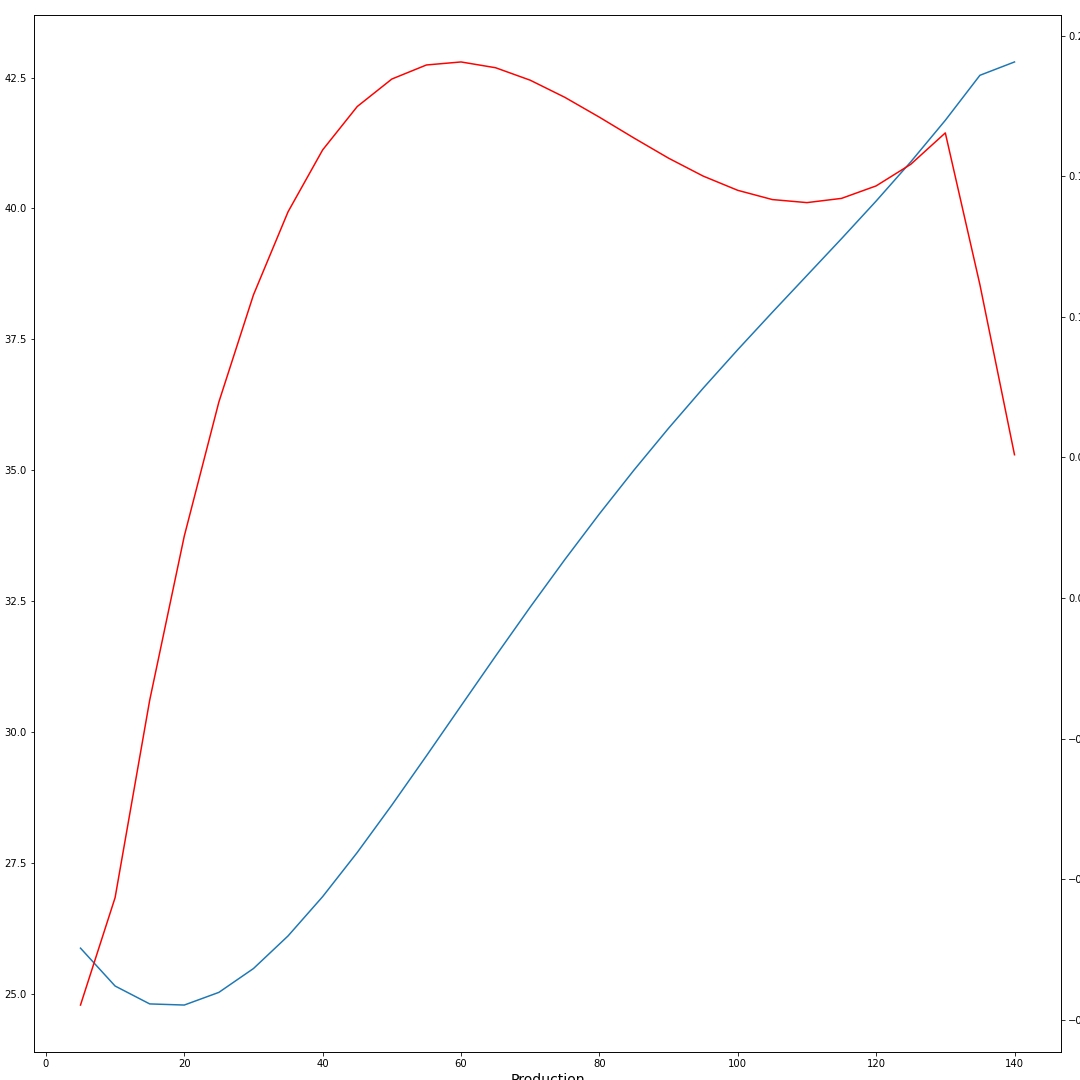

In [35]:
path_pump_pass = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                 'ГРАД', oilfield_, r'Результаты\Pump passport\1982, Freq = 55.0, mu = 7.76.jpg')
Image(filename = path_pump_pass, width=500, height=500) 

Характеристика насоса на частоте 55 Гц и вязкости 7.76 (Python)

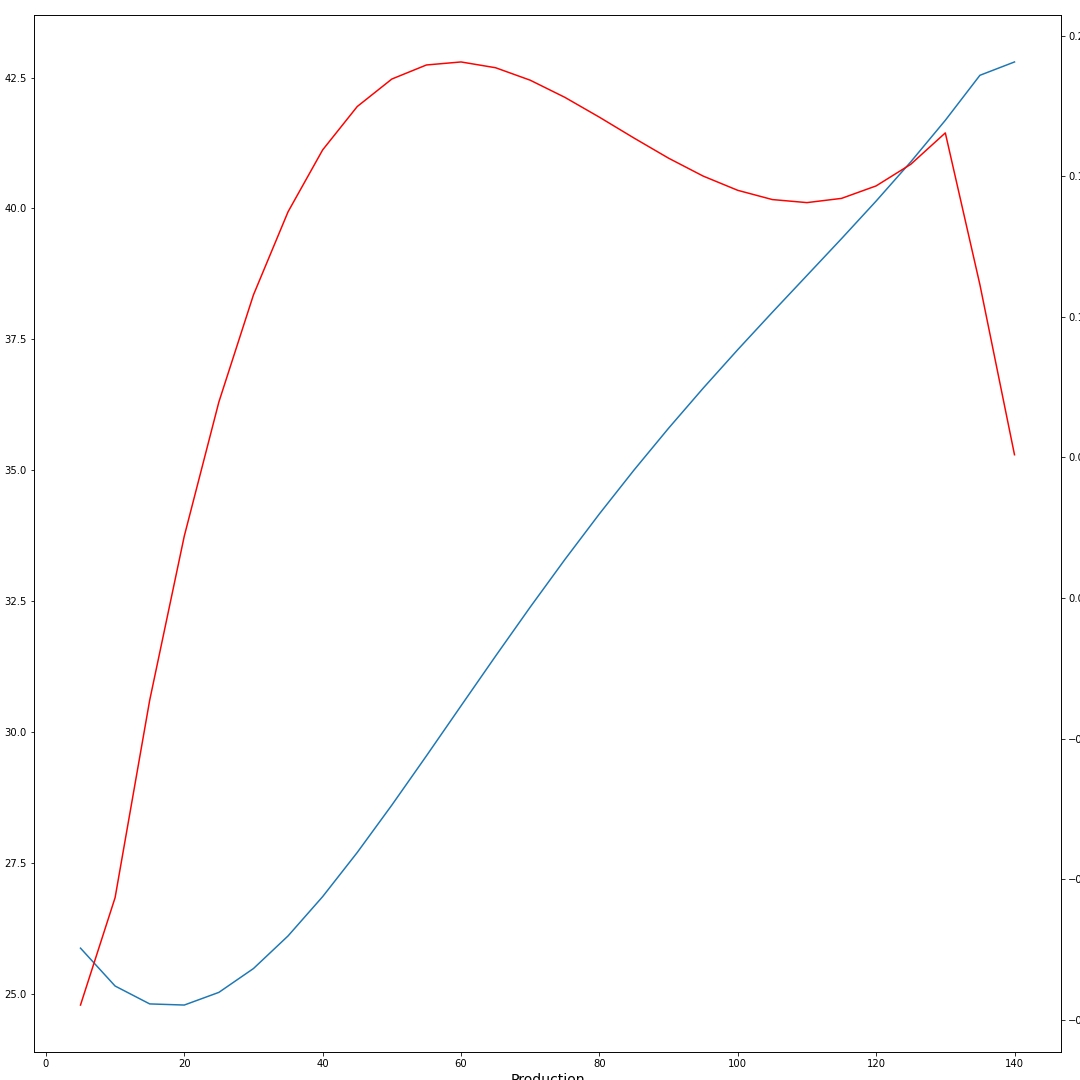

In [36]:
path_pump_pass = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                 'ГРАД', oilfield_, r'Результаты_py\Pump passport\1982, Freq = 55.0, mu = 7.76.jpg')
Image(filename = path_pump_pass, width=500, height=500) 

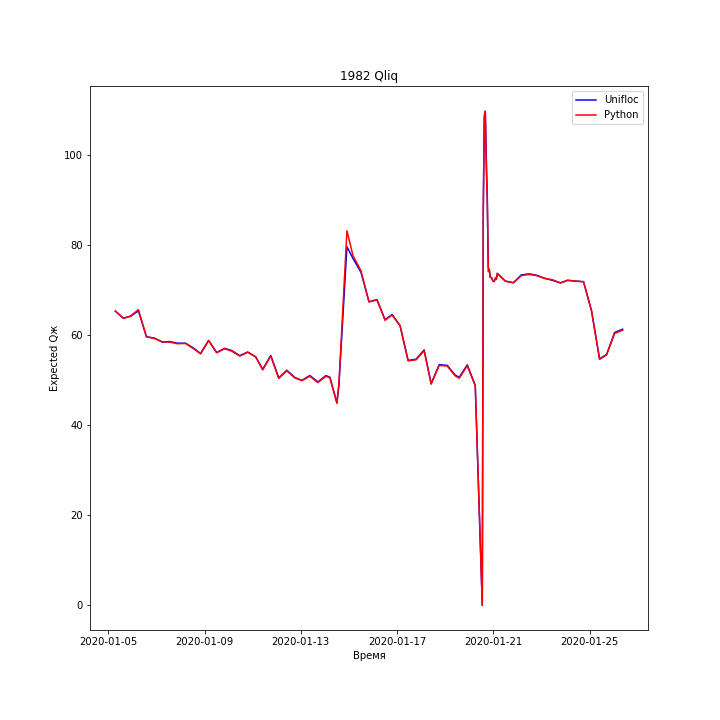

In [37]:
register_matplotlib_converters()
path = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                      'ГРАД', oilfield_, r'Результаты_py\predicted_qliq', well_name + '.png')
plt.figure(figsize = (10,10))
plt.title(well_name + ' Qliq')
plt.plot(df_res.index.values, expected_q_8h[0], color = 'b', label = 'Unifloc')
plt.plot(df_res.index.values, expected_q_8h_py[0], color = 'r', label = 'Python')
plt.xlabel('Время')
plt.ylabel('Expected Qж')
plt.legend()
plt.savefig(path, quality=100)
plt.close()
Image(filename = path, width=500, height=500) 